In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Importing data

## Target

In [2]:
LOCAL_PATH = '/Users/R/code/HaukeFock/predict_energy_generation/raw_data/daily/energy_generation_data/df_deutschland.csv'

def get_target_data(path=LOCAL_PATH, target='wind', hourly=True):
    if hourly:
        path = path.replace('daily/','hourly/')
    df = pd.read_csv(path, index_col='Date')
    df.index = pd.to_datetime(df.index)
    if hourly:
        df = df.resample('h').sum()    
    else:
        df = df.resample('d').sum()
    if target == 'wind':
        return df[['Wind offshore[MWh]','Wind onshore[MWh]']].sum(axis=1)
    if target == 'solar':
        return df['Photovoltaics[MWh]']

target_df = get_target_data(target='wind', hourly=True)


In [3]:
target_pipe = Pipeline(steps=[
    ('scaler', MinMaxScaler())
])

target_scaled = target_pipe.fit_transform(pd.DataFrame(target_df.to_numpy(), index=target_df.index))
target_scaled_df = pd.Series(target_scaled.squeeze(), index=target_df.index)

## Features

In [6]:
def get_best_station_ids(features_df, target_df, corr=0.6):
    features_df['target'] = target_df
    corr_df = features_df.corr()
    best_stations = list(corr_df['target'][corr_df['target']>=corr].index)[:-1]
    init_length = len(features_df.columns)
    final_length = len(best_stations)
    print(f'Droped {init_length - final_length} stations!')
    
    return best_stations

FEATURES_PATH = '/Users/R/code/HaukeFock/predict_energy_generation/raw_data/daily/features'

hourly_files = {'wind_speed': 'wind_hourly_clean.csv',
                 'air_pressure': 'hourly_airp_df.csv',
                 'humidity': 'hourly_humidity_df.csv',
                 'temperature': 'hourly_temperature_df.csv',
                 'clouds': 'hourly_cloud_df.csv'}

daily_files = {'wind_speed': 'winddailyofeverystation.csv',
               'air_pressure': 'daily_airp_df.csv',
               'humidity': None,
               'temperature': None,
               'clouds': None}


def get_features_data(path=FEATURES_PATH, features=['wind_speed'], optimized=False, grouped=True, hourly=True):
    df = pd.DataFrame(index=target_df.index)
    
    for feature in features:
        if hourly and hourly_files[feature]:
            path = FEATURES_PATH.replace('/daily/features',f'/hourly/features/{hourly_files[feature]}')
        elif daily_files[feature]:
            path = f'{path}/winddailyofeverystation.csv'
        else:
            continue
        feat_df = pd.read_csv(path, index_col='Date')
        feat_df.index = pd.to_datetime(feat_df.index)
        if optimized:
            best_stations = get_best_station_ids(feat_df, target_df)
            feat_df = feat_df[best_stations]
        if grouped:
            feat_df = feat_df.mean(axis=1)
            df[feature] = feat_df
        else:
            feat_df.rename(columns = {column: f'{column}_{feature[0]}' for column in feat_df.columns}, inplace=True)
            df = df.join(feat_df)

    return df

In [7]:
features_df = get_features_data(features=['wind_speed', 'air_pressure', 'humidity', 'temperature'], optimized=False, hourly=True, grouped=True)

In [9]:
feature_pipe = Pipeline(steps=[
    ('scaler', MinMaxScaler())
])

feat_scaled = feature_pipe.fit_transform(features_df)
feat_scaled_df = pd.DataFrame(feat_scaled, columns=features_df.columns, index=features_df.index)

##  Forecasted

In [8]:
FORCASTED_PATH = '/Users/R/code/HaukeFock/predict_energy_generation/raw_data/daily/forecasted_generation_data/df_deutschland_forecasted.csv'

def get_forcasted_data(path=FORCASTED_PATH, target='wind', hourly=False):
    if hourly:
        path = path.replace('/daily/', '/hourly/')
    df = pd.read_csv(path, index_col='Date')
    df.index = pd.to_datetime(df.index)
    if hourly:
        df = df.resample('h').sum()
    else:
        df = df.resample('d').sum()
    if target == 'wind':
        return df[['Wind offshore[MWh]','Wind onshore[MWh]']].sum(axis=1)
    if target == 'solar':
        return df['Photovoltaics[MWh]']

forcasted_df = get_forcasted_data(target='wind', hourly=True)
    

# Statistical exploration

## Train Test Split

In [94]:
def get_X_y(target_df, features_df, init_date=dt.datetime(2020,7,1), end_date=dt.datetime(2021,6,15), scaled=False):
    '''return the the target and features data between the init_date and end_date time window'''
    if scaled:
        target_df = pd.Series(np.log(target_df.values), index=target_df.index)
    X = features_df.loc[init_date:end_date,:]
    y = target_df.loc[init_date:end_date]
    return X, y

def train_test_split(X, y, train_end='2021-3-31', test_init='2021-4-1', test_end='2021-4-30'):
    X_train = X.loc[:train_end]
    X_test = X.loc[test_init:test_end]
    y_train = y.loc[:train_end]
    y_test = y.loc[test_init:test_end]
    
    return X_train, X_test, y_train, y_test

<ipython-input-94-e772b5db1cc8>:4: RuntimeWarning: divide by zero encountered in log
  target_df = pd.Series(np.log(target_df.values), index=target_df.index)


In [ ]:
X, y = get_X_y(target_df, features_df, init_date=dt.date(2020,6,1), end_date=dt.date(2021,1,5), scaled=True)
X_train, X_test, y_train, y_test = train_test_split(X, y)

## Stationarity

### Visually

<AxesSubplot:>

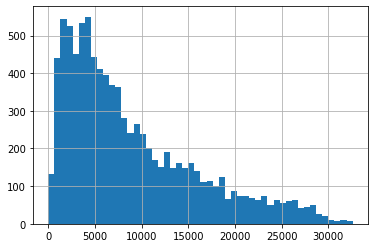

In [9]:
y.hist(bins=50)

<AxesSubplot:xlabel='Date'>

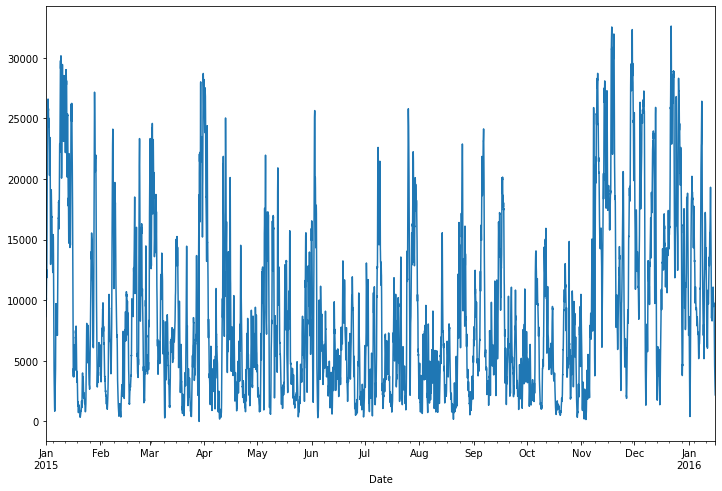

In [10]:
plt.subplots(figsize=(12,8))
y.plot()

###  Calculations (mean, variance and autocorrelation)

In [143]:
def plot_autocorrelation(y, d=0, D=0, m=0):
    y = pd.Series(y)
    if D > 0:
        for i in range(D):
            y = y.diff(m).dropna()
    if d > 0:
        for i in range(d):
            y = y.diff(1).dropna()
    fig = plt.figure(figsize=(20,10))
    ax1 = fig.add_subplot(2,1,1)
    ax2 = fig.add_subplot(2,2,3)
    ax3 = fig.add_subplot(2,2,4)
    ax1.plot(y)
    plot_acf(y, lags = 50, ax=ax2);
    plot_pacf(y, lags=50, ax=ax3, color='r');
    plt.show()

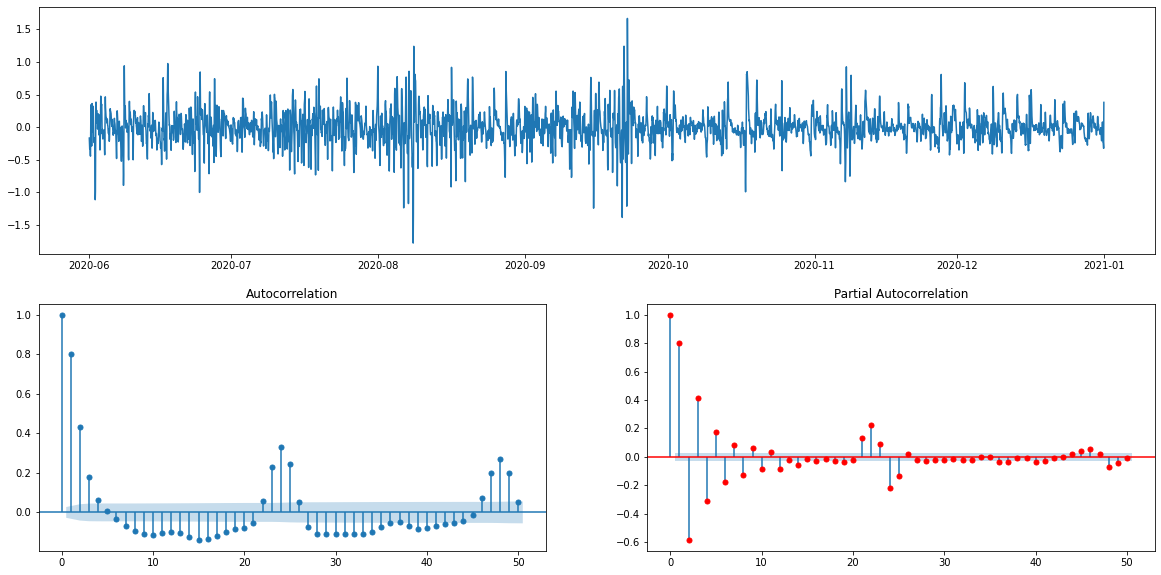

In [144]:
plot_autocorrelation(y_train, d=0, D=1, m=2)

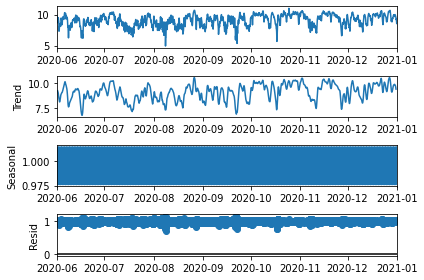

In [145]:
result_add = seasonal_decompose(y_train, model='multiplicative')
result_add.plot();

<AxesSubplot:xlabel='Date'>

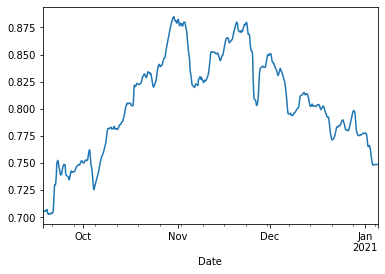

In [146]:
y.rolling(window=int(len(y)/2)).var().dropna().plot()

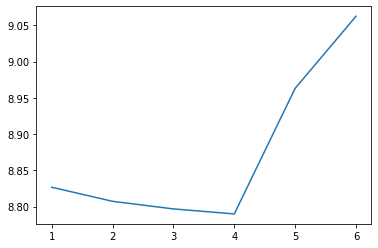

In [147]:
means = []

for year in range(1, 8):
    means.append(y[f'2020-{year}':f'2020-{year+4}'].mean())

plt.plot(means)

In [154]:
# p-value (should be less than 0.05 to be sattionary)
adfuller(y_train)[1]

4.7329962368288775e-11

0.008671698273998753

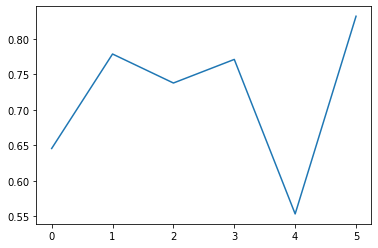

In [156]:
var = []

for month in range(6, 12):
    var.append(y[f'2020-{month}'].var())

plt.plot(var)
np.array(var).var()

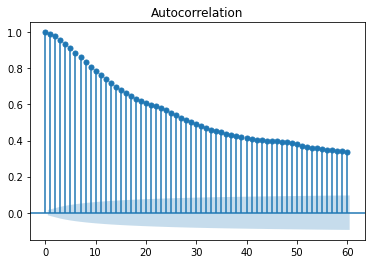

In [301]:
plot_acf(y.dropna(), lags=60);

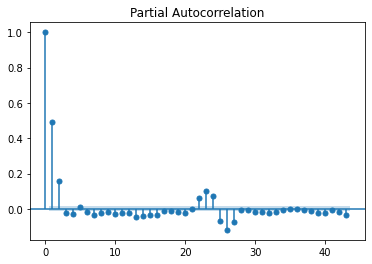

In [302]:
plot_pacf(y.diff().dropna());

In [157]:
adfuller(y.diff(24).dropna())

(-13.015266629267176,
 2.5187179923880642e-24,
 32,
 5176,
 {'1%': -3.4316140158442305,
  '5%': -2.8620985625001385,
  '10%': -2.56706732277764},
 -10244.134358646596)

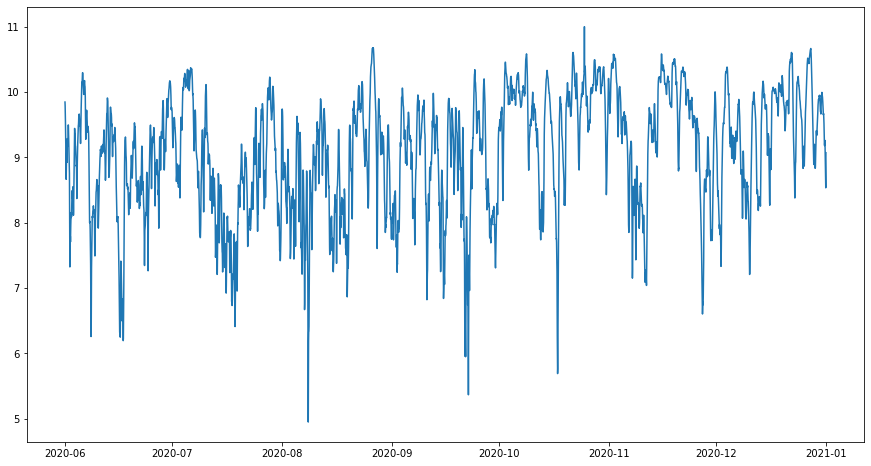

In [158]:
plt.subplots(figsize=(15,8))
plt.plot(y_train)

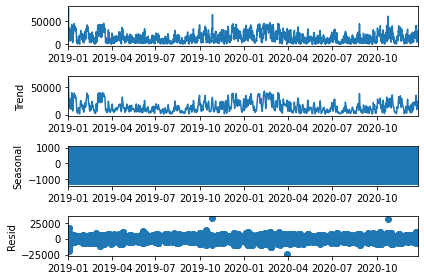

In [189]:
result_mul = seasonal_decompose(y_train, model='addictive')
result_mul.plot();

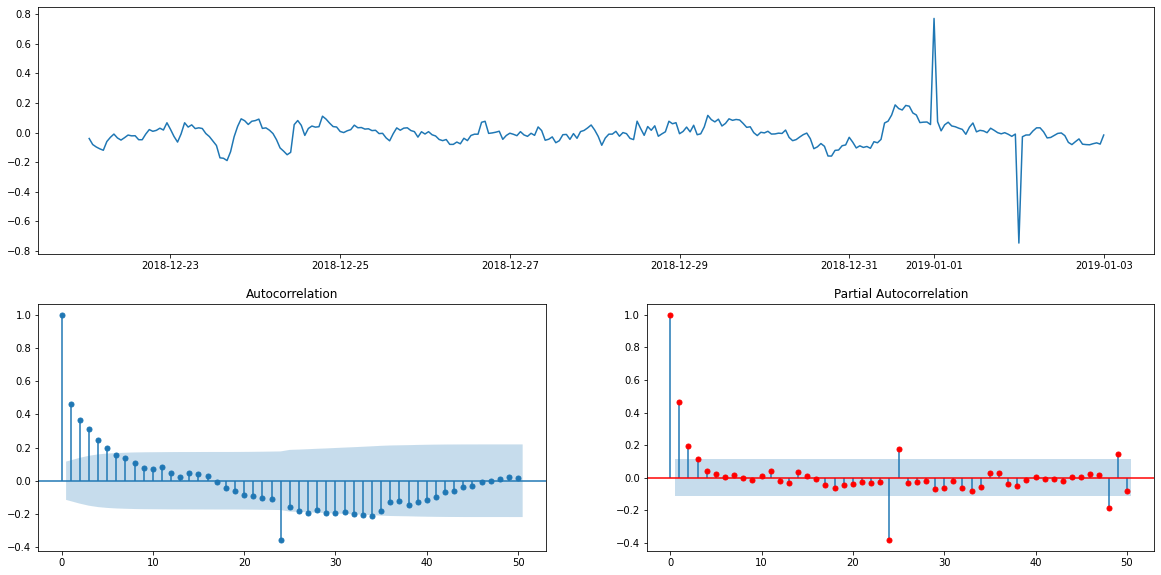

In [68]:
plot_autocorrelation(y['2018-12-22':], d=1, D=0, m=24)

# Models

## Auto-ARIMA 0

In [176]:
# split data
X, y = get_X_y(target_df, features_df)
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [177]:
import pmdarima as pm

smodel = pm.auto_arima(y_train, m=24, X=X_train.to_numpy(),
                       start_p=0, max_p=2,
                       start_d=0, max_d=1,
                       start_q=0, max_q=2,
                       start_P=0, max_P=2,
                       start_D=0, max_D=3,
                       start_Q=0, max_Q=2,
                       seasonal=True, trace=True, njobs=-1, error_action='ignore',  
                       stepwise=False, suppress_warnings=True)

 ARIMA(0,0,0)(0,0,0)[24] intercept   : AIC=130482.665, Time=0.27 sec
 ARIMA(0,0,0)(0,0,1)[24] intercept   : AIC=129205.768, Time=30.69 sec
 ARIMA(0,0,0)(0,0,2)[24] intercept   : AIC=128809.657, Time=52.90 sec
 ARIMA(0,0,0)(1,0,0)[24] intercept   : AIC=127960.365, Time=28.84 sec
 ARIMA(0,0,0)(1,0,1)[24] intercept   : AIC=inf, Time=39.53 sec
 ARIMA(0,0,0)(1,0,2)[24] intercept   : AIC=127596.944, Time=126.87 sec
 ARIMA(0,0,0)(2,0,0)[24] intercept   : AIC=inf, Time=125.89 sec
 ARIMA(0,0,0)(2,0,1)[24] intercept   : AIC=inf, Time=122.65 sec
 ARIMA(0,0,0)(2,0,2)[24] intercept   : AIC=inf, Time=134.30 sec
 ARIMA(0,0,1)(0,0,0)[24] intercept   : AIC=123252.549, Time=3.35 sec
 ARIMA(0,0,1)(0,0,1)[24] intercept   : AIC=122291.745, Time=39.67 sec
 ARIMA(0,0,1)(0,0,2)[24] intercept   : AIC=121811.240, Time=127.42 sec
 ARIMA(0,0,1)(1,0,0)[24] intercept   : AIC=122647.337, Time=43.41 sec
 ARIMA(0,0,1)(1,0,1)[24] intercept   : AIC=123217.965, Time=43.95 sec
 ARIMA(0,0,1)(1,0,2)[24] intercept   : AIC=12

In [178]:
smodel.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                 6576
Model:             SARIMAX(2, 0, 1)x(2, 0, [], 24)   Log Likelihood              -55357.331
Date:                             Sat, 19 Jun 2021   AIC                         110736.662
Time:                                     02:53:11   BIC                         110811.365
Sample:                                          0   HQIC                        110762.485
                                            - 6576                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.8856    634.035     -0.003      0.998   -1244.572    1240.800
x1          6979.6363    117.021     59.644      0.000    6750.280    7208.993
x2           -34.6794     44.671     -0.776      0.438    -122.233      52.874
x3           299.5290     22.061     13.578      0.000     256.291     342.767
x4            22.3954     68.966      0.325      0.745    -112.775     157.566
ar.L1          1.6607      0.030     56.261      0.000       1.603       1.719
ar.L2         -0.6815      0.029    -23.450      0.000      -0.738      -0.625
ma.L1         -0.5190      0.029    -17.777      0.000      -0.576      -0.462
ar.S.L24       0.1704      0.004     47.816      0.000       0.163       0.177
ar.S.L48       0.1442      0.005     29.559      0.000       0.135       0.154
sigma2      1.189e+06   3392.090    350.581      0.000    1.18e+06     1.2e+06
===================================================================================
Ljung-Box (L1) (Q):                   3.24   Jarque-Bera (JB):          29590099.13
Prob(Q):                              0.07   Prob(JB):                         0.00
Heteroskedasticity (H):               1.76   Skew:                            -0.31
Prob(H) (two-sided):                  0.00   Kurtosis:                       331.62
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [179]:
central, confint = smodel.predict(n_periods=len(y_test), X=X_test, return_conf_int=True)
index_y_test = y_test.index #pd.date_range(df_test.index[-1], periods = n_periods, freq='MS')

# make series for plotting purpose
central = pd.Series(central, index=index_y_test)
lower = pd.Series(confint[:, 0], index=index_y_test)
upper = pd.Series(confint[:, 1], index=index_y_test)

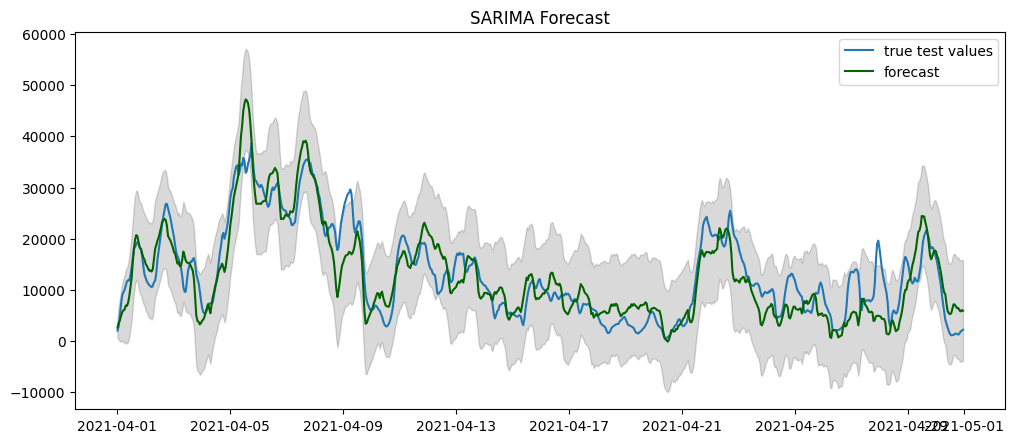

In [180]:
# Plot
plt.figure(figsize=(12,5), dpi=100)
#plt.plot(y_train, label = "train values")
plt.plot(y_test, label = "true test values")
plt.plot(central, color='darkgreen',label = "forecast")
plt.fill_between(lower.index, 
                 lower, 
                 upper, 
                 color='k', alpha=.15)

plt.title("SARIMA Forecast")
plt.legend()
plt.show()

In [181]:
mean_absolute_percentage_error(y_test, central)

41.10573089165641

In [182]:
# MPAE
(y_test-central).abs().mean()/y_test.mean()*100

25.12885794134127

## Auto-ARIMA 1

In [302]:
# split data
X, y = get_X_y(target_df, features_df, init_date=dt.date(2020,7,1), end_date=dt.date(2021,1,31), scaled=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_end='2020-12-31', test_init='2021-1-1', test_end='2021-1-4',)

<ipython-input-13-525d6fe1ef14>:4: RuntimeWarning: divide by zero encountered in log
  target_df = pd.Series(np.log(target_df.values), index=target_df.index)


In [291]:
import pmdarima as pm

smodel_1 = pm.auto_arima(y_train, m=12, X=X_train.to_numpy(),
                       start_p=0, max_p=2,
                       start_d=0, max_d=1,
                       start_q=0, max_q=2,
                       start_P=0, max_P=2,
                       start_D=0, max_D=1,
                       start_Q=0, max_Q=2,
                       seasonal=True, trace=True, njobs=-1, error_action='ignore',  
                       stepwise=False, suppress_warnings=True)

 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=86704.174, Time=0.19 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : AIC=86365.301, Time=9.48 sec
 ARIMA(0,0,0)(0,0,2)[12] intercept   : AIC=85610.895, Time=12.67 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : AIC=86055.888, Time=2.60 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : AIC=85727.086, Time=10.74 sec
 ARIMA(0,0,0)(1,0,2)[12] intercept   : AIC=inf, Time=30.61 sec
 ARIMA(0,0,0)(2,0,0)[12] intercept   : AIC=inf, Time=26.44 sec
 ARIMA(0,0,0)(2,0,1)[12] intercept   : AIC=inf, Time=25.98 sec
 ARIMA(0,0,0)(2,0,2)[12] intercept   : AIC=inf, Time=26.34 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : AIC=81930.101, Time=2.29 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=81659.434, Time=11.30 sec
 ARIMA(0,0,1)(0,0,2)[12] intercept   : AIC=81537.779, Time=27.40 sec
 ARIMA(0,0,1)(1,0,0)[12] intercept   : AIC=81358.764, Time=9.33 sec
 ARIMA(0,0,1)(1,0,1)[12] intercept   : AIC=81730.218, Time=13.44 sec
 ARIMA(0,0,1)(1,0,2)[12] intercept   : AIC=inf, Time=31.13 sec


In [293]:
smodel_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                 4416
Model:             SARIMAX(2, 0, 1)x(2, 0, [], 12)   Log Likelihood              -37157.250
Date:                             Thu, 17 Jun 2021   AIC                          74336.500
Time:                                     00:22:25   BIC                          74406.823
Sample:                                          0   HQIC                         74361.303
                                            - 4416                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.7821   1172.863     -0.002      0.999   -2300.552    2296.988
x1          7240.8715    146.956     49.272      0.000    6952.843    7528.900
x2           -37.3738     53.287     -0.701      0.483    -141.815      67.067
x3           319.0550     28.841     11.062      0.000     262.527     375.583
x4            67.7145     94.156      0.719      0.472    -116.828     252.257
ar.L1          1.5823      0.037     42.962      0.000       1.510       1.655
ar.L2         -0.6112      0.036    -16.800      0.000      -0.682      -0.540
ma.L1         -0.4230      0.036    -11.662      0.000      -0.494      -0.352
ar.S.L12      -0.0020      0.019     -0.103      0.918      -0.039       0.035
ar.S.L24       0.2299      0.003     70.822      0.000       0.224       0.236
sigma2      1.224e+06   5042.864    242.801      0.000    1.21e+06    1.23e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.65   Jarque-Bera (JB):          25635025.40
Prob(Q):                              0.42   Prob(JB):                         0.00
Heteroskedasticity (H):               0.69   Skew:                            -2.35
Prob(H) (two-sided):                  0.00   Kurtosis:                       376.23
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [294]:
central, confint = smodel_1.predict(n_periods=len(y_test), X=X_test, return_conf_int=True)
index_y_test = y_test.index #pd.date_range(df_test.index[-1], periods = n_periods, freq='MS')

# make series for plotting purpose
central = pd.Series(central, index=index_y_test)
lower = pd.Series(confint[:, 0], index=index_y_test)
upper = pd.Series(confint[:, 1], index=index_y_test)

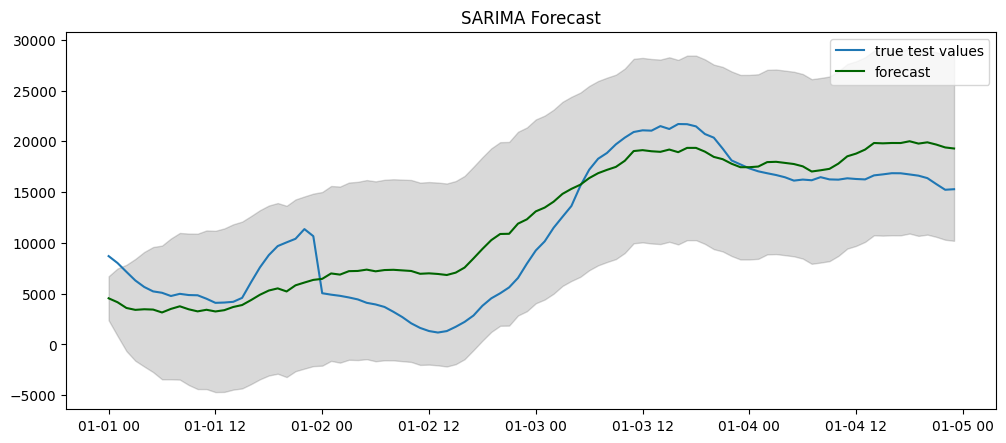

In [295]:
# Plot
plt.figure(figsize=(12,5), dpi=100)
#plt.plot(y_train, label = "train values")
plt.plot(y_test, label = "true test values")
plt.plot(central, color='darkgreen',label = "forecast")
plt.fill_between(lower.index, 
                 lower, 
                 upper, 
                 color='k', alpha=.15)

plt.title("SARIMA Forecast")
plt.legend()
plt.show()

In [296]:
mean_absolute_percentage_error(y_test, central)

57.45237617421366

## SARIMAX 0

In [169]:
def plot_forecast(fc, train, test, upper=None, lower=None):
    is_confidence_int = isinstance(upper, np.ndarray) and isinstance(lower, np.ndarray)
    # Prepare plot series
    fc_series = pd.Series(fc, index=test.index)
    lower_series = pd.Series(upper, index=test.index) if is_confidence_int else None
    upper_series = pd.Series(lower, index=test.index) if is_confidence_int else None

    # Plot
    plt.figure(figsize=(10,4), dpi=100)
    plt.plot(train, label='training', color='black')
    plt.plot(test, label='actual', color='black', ls='--')
    plt.plot(fc_series, label='forecast', color='orange')
    if is_confidence_int:
        plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.15)
    plt.title('Forecast vs Actuals')
    plt.legend(loc='upper left', fontsize=8);

In [170]:
sarimax = SARIMAX(endog=y_train, exog=X_train, order=(2,1,0), seasonal_order=(2,0,0,24)).fit()

/Users/R/.pyenv/versions/3.8.6/envs/predict_energy_generation/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [190]:
y_pred = sarimax.predict(len(X_test), exog=X_test, alpha=0.05)

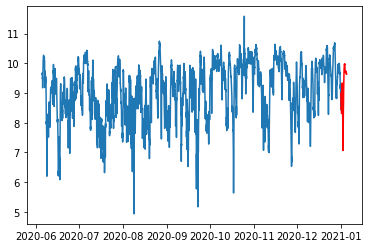

In [185]:
plt.plot(y_pred)
plt.plot(y_test, color='r')
#plt.plot(central, color='g')

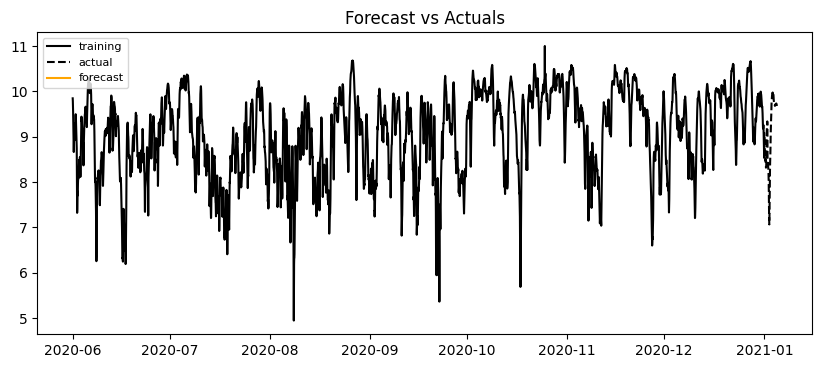

In [186]:
plot_forecast(y_pred, y_train, y_test)

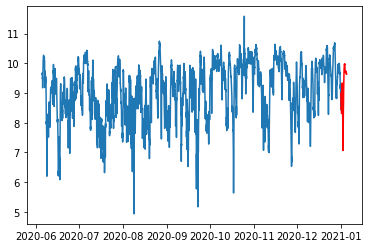

In [189]:
plt.plot(y_pred)
plt.plot(y_test, color='r')

In [180]:
y_pred.shape

(5041,)

In [179]:
mean_absolute_percentage_error(np.exp(y_test), np.exp(y_pred))

ValueError: operands could not be broadcast together with shapes (96,) (5041,) 

## SARIMAX 1

 **Model_1**:
 - Train size = 6 month
 - Test size = 4 day
 - Features: 'wind_speed', 'air_pressure', 'clouds', 'humidity', 'temperature'
 - Scaled data = log(target)
 - model: **SARIMAX (2,0,2)(2,0,2)[24]**

In [21]:
# split data
X, y = get_X_y(target_df, features_df, init_date=dt.date(2020,6,1), end_date=dt.date(2021,1,5), scaled=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_hours=24*days)

# train model
sarimax_1 = SARIMAX(y_train, 
                    exog=X_train, order=(2,0,2), 
                    seasonal_order=(2,0,2,24), 
                    time_varying_regression=False).fit()

#get predicitons and confidence interval
sarimax_result = sarimax_1.get_prediction(start=X_test.index[0], end=X_test.index[-1], exog=X_test)
confint = sarimax_result.conf_int(alpha=0.05)
central = sarimax_result.predicted_mean
lower = confint['lower y']
upper = confint['upper y']

<ipython-input-13-525d6fe1ef14>:4: RuntimeWarning: divide by zero encountered in log
  target_df = pd.Series(np.log(target_df.values), index=target_df.index)


In [95]:
# model MAPE
mean_absolute_percentage_error(y_test, central)

7.195811338454076

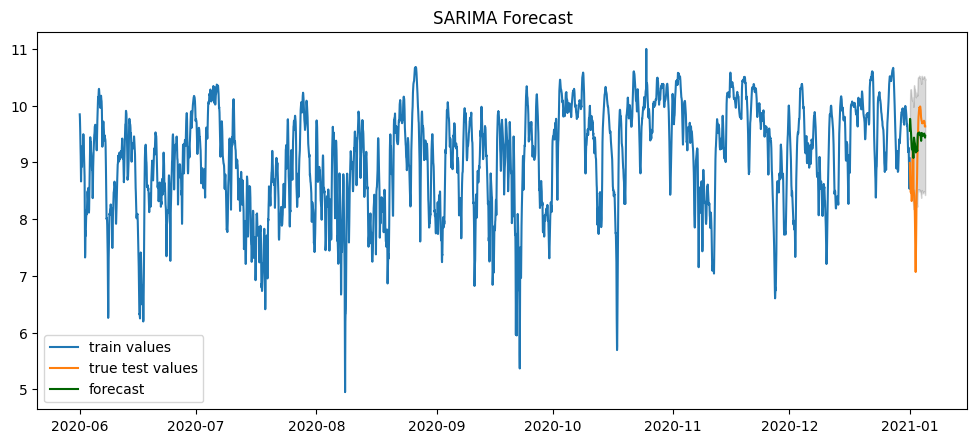

In [65]:
# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(y_train, label = "train values")
plt.plot(y_test, label = "true test values")
plt.plot(central, color='darkgreen',label = "forecast")
plt.fill_between(lower.index, 
                 lower, 
                 upper, 
                 color='k', alpha=.15)

plt.title("SARIMA Forecast")
plt.legend()
plt.show()

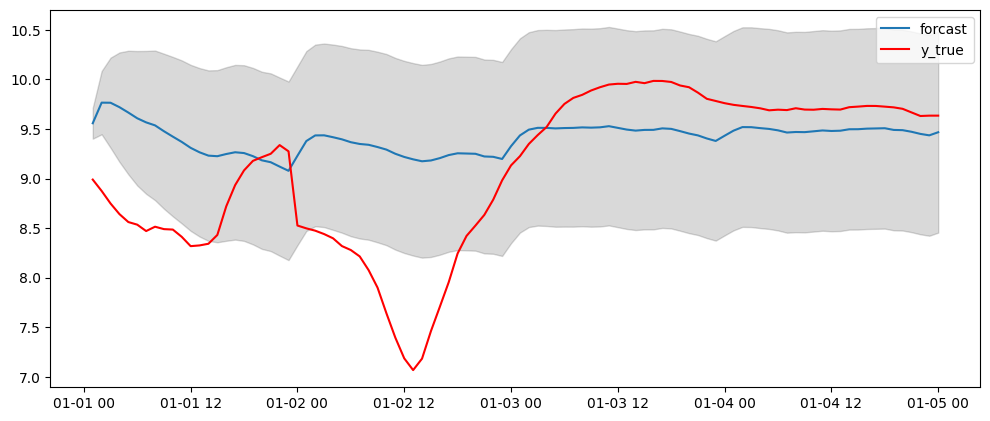

In [78]:
plt.figure(figsize=(12,5), dpi=100)
plt.plot(central, label='forcast')
plt.plot(y_test, c='r', label='y_true')
plt.fill_between(lower.index, 
                 lower, 
                 upper, 
                 color='k', alpha=.15)
plt.legend();

## SARIMAX 2

 **Model_2**:
 - Train size = 3 month
 - Test size = 15 day
 - Features: 'wind_speed', 'air_pressure', 'clouds', 'humidity', 'temperature'
 - Scaled data = false
 - model: **SARIMAX (2,1,0)(2,0,1)[24]**

In [105]:
# split data
X, y = get_X_y(target_df, features_df, init_date=dt.date(2020,10,1), end_date=dt.date(2021,1,15))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_hours=24*15)

# train model
sarimax_2 = SARIMAX(y_train, 
                    exog=X_train, order=(2,1,0), 
                    seasonal_order=(2,0,1,24), 
                    time_varying_regression=False).fit()

In [111]:
sarimax_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                 2185
Model:             SARIMAX(2, 1, 0)x(2, 0, [1], 24)   Log Likelihood              -18654.276
Date:                              Wed, 16 Jun 2021   AIC                          37330.552
Time:                                      21:19:59   BIC                          37393.130
Sample:                                  10-01-2020   HQIC                         37353.427
                                       - 12-31-2020                                         
Covariance Type:                                opg                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
wind_speed    5634.2739    260.024     21.668      0.000    5124.636    6143.911
air_pressure  -280.9006     88.113     -3.188      0.001    -453.599    -108.203
clouds        -459.8361    184.187     -2.497      0.013    -820.835     -98.837
humidity       291.7880     56.108      5.200      0.000     181.819     401.757
temperature   -514.3509    212.854     -2.416      0.016    -931.537     -97.165
ar.L1           -0.0014      0.005     -0.253      0.800      -0.012       0.009
ar.L2            0.0120      0.006      2.092      0.036       0.001       0.023
ar.S.L24         0.9507      0.044     21.654      0.000       0.865       1.037
ar.S.L48         0.0058      0.006      0.944      0.345      -0.006       0.018
ma.S.L24        -0.9504      0.044    -21.732      0.000      -1.036      -0.865
sigma2        1.516e+06   1.05e+04    144.173      0.000     1.5e+06    1.54e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):           9269805.33
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.17   Skew:                            -0.21
Prob(H) (two-sided):                  0.00   Kurtosis:                       322.16
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [106]:
#get predicitons and confidence interval
sarimax_result = sarimax_1.get_prediction(start=X_test.index[0], end=X_test.index[-1], exog=X_test)
confint = sarimax_result.conf_int(alpha=0.05)
central = sarimax_result.predicted_mean
lower = confint['lower y']
upper = confint['upper y']

In [107]:
# model MAPE
mean_absolute_percentage_error(y_test, central)

81.5546368265491

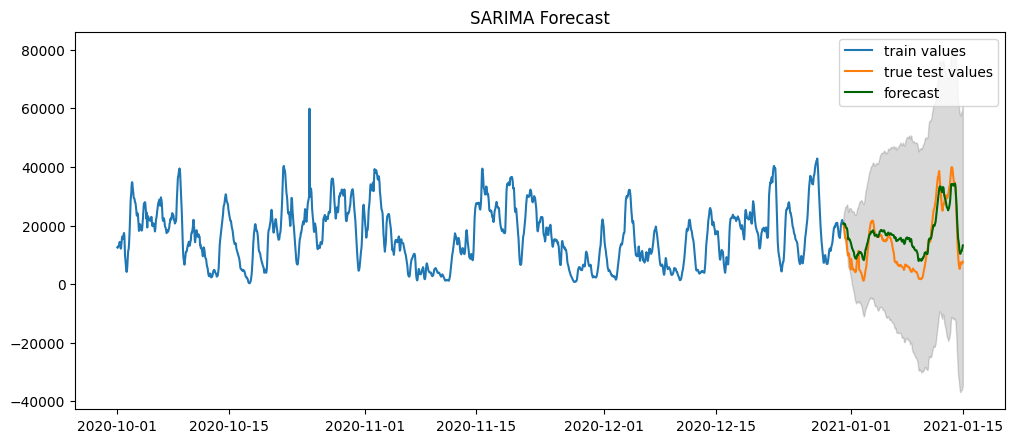

In [108]:
# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(y_train, label = "train values")
plt.plot(y_test, label = "true test values")
plt.plot(central, color='darkgreen',label = "forecast")
plt.fill_between(lower.index, 
                 lower, 
                 upper, 
                 color='k', alpha=.15)

plt.title("SARIMA Forecast")
plt.legend()
plt.show()

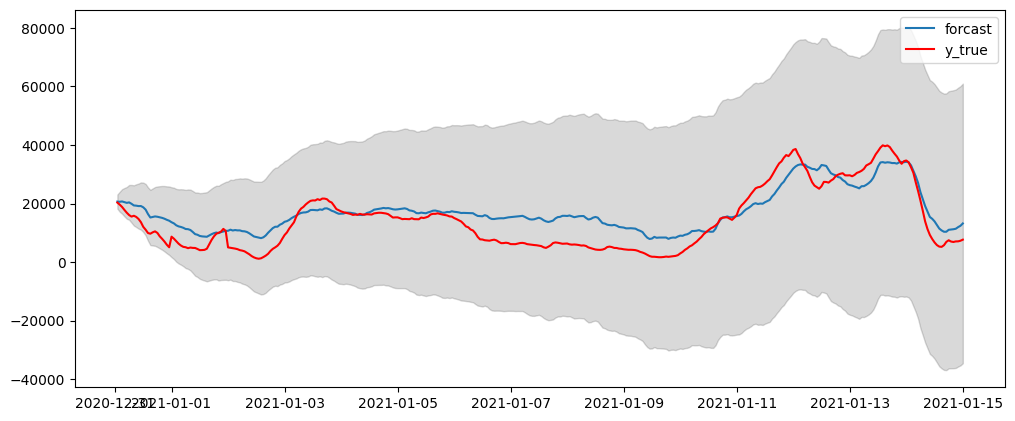

In [109]:
plt.figure(figsize=(12,5), dpi=100)
plt.plot(central, label='forcast')
plt.plot(y_test, c='r', label='y_true')
plt.fill_between(lower.index, 
                 lower, 
                 upper, 
                 color='k', alpha=.15)
plt.legend();

## SARIMAX 3

 **Model_3**:
 - Train size = 3 month
 - Test size = 15 day
 - Features: 'wind_speed', 'air_pressure', 'clouds', 'humidity', 'temperature'
 - Scaled data = false
 - model: **SARIMAX (2,1,2)(2,0,2)[12]**

In [128]:
# split data
X, y = get_X_y(target_df, features_df, init_date=dt.date(2020,10,1), end_date=dt.date(2021,1,15))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_hours=24*15)

# train model
sarimax_3 = SARIMAX(y_train, 
                    exog=X_train, order=(2,1,2), 
                    seasonal_order=(2,0,2,12), 
                    time_varying_regression=False).fit()

/Users/R/.pyenv/versions/3.8.6/envs/predict_energy_generation/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [129]:
sarimax_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                 2185
Model:             SARIMAX(2, 1, 2)x(2, 0, 2, 12)   Log Likelihood              -18652.697
Date:                            Wed, 16 Jun 2021   AIC                          37333.394
Time:                                    21:39:09   BIC                          37413.039
Sample:                                10-01-2020   HQIC                         37362.508
                                     - 12-31-2020                                         
Covariance Type:                              opg                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
wind_speed    5634.2739    259.779     21.689      0.000    5125.117    6143.431
air_pressure  -280.9106     91.436     -3.072      0.002    -460.122    -101.699
clouds        -459.8380    183.219     -2.510      0.012    -818.941    -100.735
humidity       291.7657     56.768      5.140      0.000     180.502     403.029
temperature   -514.3439    213.928     -2.404      0.016    -933.635     -95.053
ar.L1            0.6831      0.465      1.469      0.142      -0.228       1.594
ar.L2           -0.0641      0.588     -0.109      0.913      -1.216       1.087
ma.L1           -0.6847      0.465     -1.474      0.141      -1.595       0.226
ma.L2            0.0774      0.587      0.132      0.895      -1.073       1.228
ar.S.L12         0.0938      0.841      0.112      0.911      -1.554       1.741
ar.S.L24         0.8673      0.820      1.057      0.290      -0.740       2.475
ma.S.L12        -0.0905      0.843     -0.107      0.915      -1.743       1.562
ma.S.L24        -0.8622      0.819     -1.052      0.293      -2.468       0.744
sigma2        1.508e+06   9490.679    158.910      0.000    1.49e+06    1.53e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):           9284189.44
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.17   Skew:                            -0.25
Prob(H) (two-sided):                  0.00   Kurtosis:                       322.41
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [130]:
#get predicitons and confidence interval
sarimax_result = sarimax_3.get_prediction(start=X_test.index[0], end=X_test.index[-1], exog=X_test)
confint = sarimax_result.conf_int(alpha=0.05)
central = sarimax_result.predicted_mean
lower = confint['lower y']
upper = confint['upper y']

In [131]:
# model MAPE
mean_absolute_percentage_error(y_test, central)

83.20463376901776

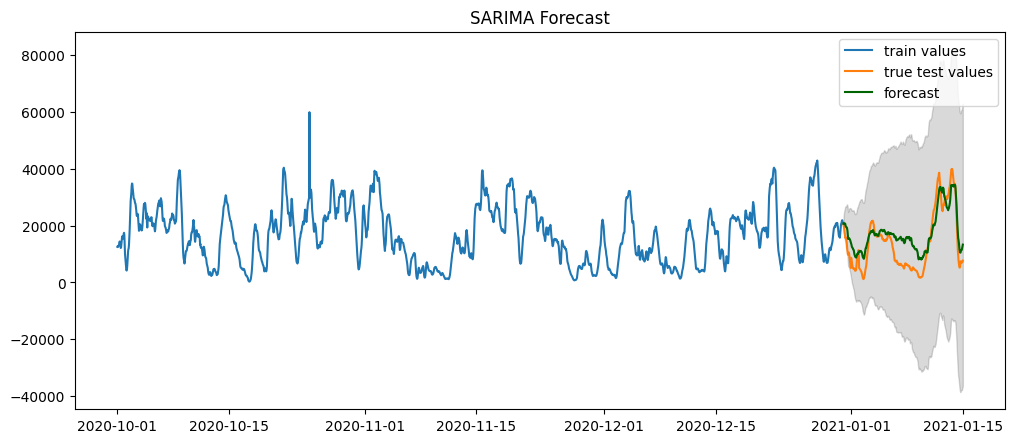

In [132]:
# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(y_train, label = "train values")
plt.plot(y_test, label = "true test values")
plt.plot(central, color='darkgreen',label = "forecast")
plt.fill_between(lower.index, 
                 lower, 
                 upper, 
                 color='k', alpha=.15)

plt.title("SARIMA Forecast")
plt.legend()
plt.show()

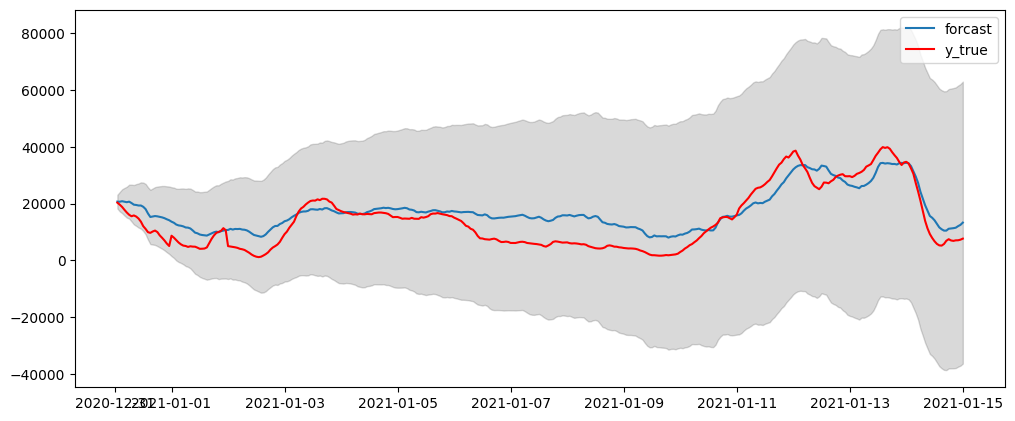

In [133]:
plt.figure(figsize=(12,5), dpi=100)
plt.plot(central, label='forcast')
plt.plot(y_test, c='r', label='y_true')
plt.fill_between(lower.index, 
                 lower, 
                 upper, 
                 color='k', alpha=.15)
plt.legend();

## SARIMAX 4

 **Model_4**:
 - Train size = 3 month
 - Test size = 15 day
 - Features: 'wind_speed', 'air_pressure', 'clouds', 'humidity', 'temperature'
 - Scaled data = false
 - model: **SARIMAX (1,1,1)(1,0,1)[24]**

In [134]:
# split data
X, y = get_X_y(target_df, features_df, init_date=dt.date(2020,10,1), end_date=dt.date(2021,1,15))
X_train, X_test, y_train, y_test = train_test_split(X, y, train_end='2020-12-31', 
                                                          test_init='2021-1-1', 
                                                          test_end='2021-1-15',)

# train model
sarimax_4 = SARIMAX(y_train, 
                    exog=X_train, order=(1,1,1), 
                    seasonal_order=(1,0,1,24), 
                    time_varying_regression=False).fit()

/Users/R/.pyenv/versions/3.8.6/envs/predict_energy_generation/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [135]:
sarimax_4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                 2208
Model:             SARIMAX(1, 1, 1)x(1, 0, 1, 24)   Log Likelihood              -18810.267
Date:                            Fri, 18 Jun 2021   AIC                          37638.535
Time:                                    18:11:57   BIC                          37689.829
Sample:                                10-01-2020   HQIC                         37657.275
                                     - 12-31-2020                                         
Covariance Type:                              opg                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
wind_speed    5540.3415    251.321     22.045      0.000    5047.761    6032.922
air_pressure   -17.1044     16.653     -1.027      0.304     -49.744      15.535
humidity       149.2738     57.919      2.577      0.010      35.754     262.794
temperature   -496.0321    210.053     -2.361      0.018    -907.729     -84.335
ar.L1            0.6105      0.583      1.048      0.295      -0.531       1.752
ma.L1           -0.6305      0.580     -1.087      0.277      -1.768       0.507
ar.S.L24         0.9771      0.013     75.675      0.000       0.952       1.002
ma.S.L24        -0.9402      0.022    -42.191      0.000      -0.984      -0.897
sigma2        1.462e+06   6878.428    212.564      0.000    1.45e+06    1.48e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.08   Jarque-Bera (JB):          10362944.83
Prob(Q):                              0.78   Prob(JB):                         0.00
Heteroskedasticity (H):               0.16   Skew:                             0.61
Prob(H) (two-sided):                  0.00   Kurtosis:                       338.69
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [136]:
#get predicitons and confidence interval
sarimax_result = sarimax_4.get_prediction(start=X_test.index[0], end=X_test.index[-1], exog=X_test)
confint = sarimax_result.conf_int(alpha=0.05)
central = sarimax_result.predicted_mean
lower = confint['lower y']
upper = confint['upper y']

In [137]:
# MPAE
(y_test-central).abs().mean()/y_test.mean()*100

41.56241448784343

In [138]:
# model MAPE
mean_absolute_percentage_error(y_test, central)

38.41748923851146

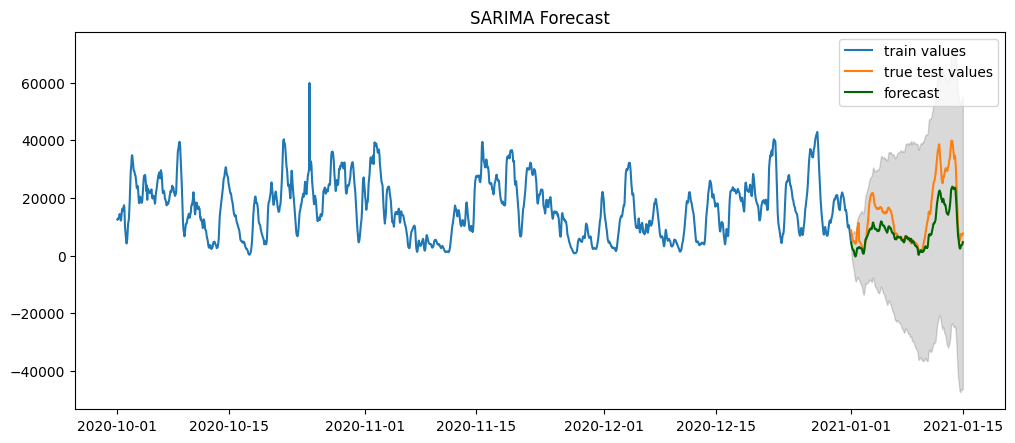

In [139]:
# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(y_train, label = "train values")
plt.plot(y_test, label = "true test values")
plt.plot(central, color='darkgreen',label = "forecast")
plt.fill_between(lower.index, 
                 lower, 
                 upper, 
                 color='k', alpha=.15)

plt.title("SARIMA Forecast")
plt.legend()
plt.show()

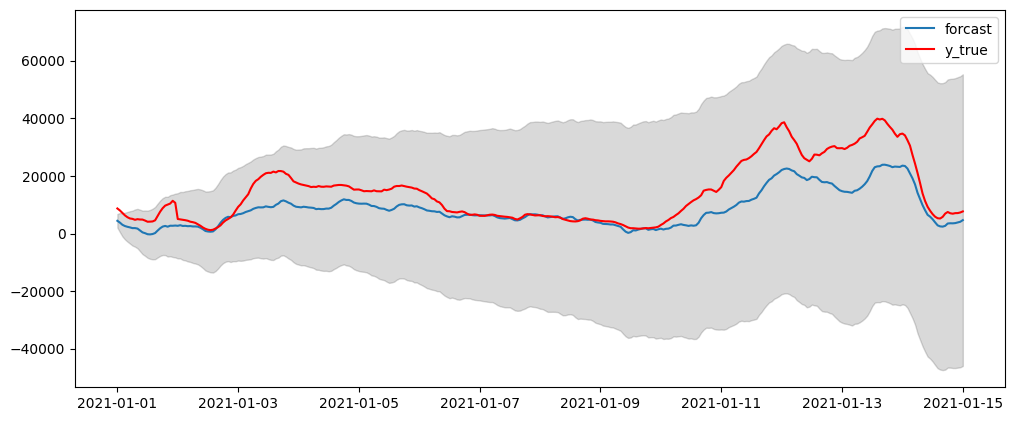

In [140]:
plt.figure(figsize=(12,5), dpi=100)
plt.plot(central, label='forcast')
plt.plot(y_test, c='r', label='y_true')
plt.fill_between(lower.index, 
                 lower, 
                 upper, 
                 color='k', alpha=.15)
plt.legend();

## SARIMAX 5

 **Model_5**:
 - Train size = 3 month
 - Test size = 15 day
 - Features: 'wind_speed', 'air_pressure', 'clouds', 'humidity', 'temperature'
 - Scaled data = target and feature
 - model: **SARIMAX (1,1,1)(1,0,2)[24]**

In [127]:
# split data
X, y = get_X_y(target_scaled_df, feat_scaled_df, init_date=dt.date(2020,10,1), end_date=dt.date(2021,1,15))
X_train, X_test, y_train, y_test = train_test_split(X, y, train_end='2020-12-31', 
                                                          test_init='2021-1-1', 
                                                          test_end='2021-1-15',)

# train model
sarimax_5 = SARIMAX(y_train, 
                    exog=X_train, order=(1,1,1), 
                    seasonal_order=(1,0,2,24), 
                    time_varying_regression=False).fit()

/Users/R/.pyenv/versions/3.8.6/envs/predict_energy_generation/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [128]:
sarimax_5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                                       y   No. Observations:                 2208
Model:             SARIMAX(1, 1, 1)x(1, 0, [1, 2], 24)   Log Likelihood                6015.722
Date:                                 Fri, 18 Jun 2021   AIC                         -12011.445
Time:                                         18:11:43   BIC                         -11954.451
Sample:                                     10-01-2020   HQIC                        -11990.622
                                          - 12-31-2020                                         
Covariance Type:                                   opg                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
wind_speed       0.7626      0.048     15.837      0.000       0.668       0.857
air_pressure    -0.4243      0.116     -3.660      0.000      -0.652      -0.197
humidity         0.1563      0.064      2.445      0.014       0.031       0.282
temperature     -0.5306      0.156     -3.408      0.001      -0.836      -0.225
ar.L1            0.7846      0.111      7.056      0.000       0.567       1.003
ma.L1           -0.7136      0.114     -6.287      0.000      -0.936      -0.491
ar.S.L24         0.6743      0.108      6.229      0.000       0.462       0.886
ma.S.L24        -0.5955      0.108     -5.527      0.000      -0.807      -0.384
ma.S.L48         0.0433      0.019      2.243      0.025       0.005       0.081
sigma2           0.0003    1.7e-06    147.275      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                  21.12   Jarque-Bera (JB):          14311696.54
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.14   Skew:                            -2.00
Prob(H) (two-sided):                  0.00   Kurtosis:                       397.48
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [129]:
#get predicitons and confidence interval
sarimax_result = sarimax_5.get_prediction(start=X_test.index[0], end=X_test.index[-1], exog=X_test)
confint = sarimax_result.conf_int(alpha=0.05)
central = sarimax_result.predicted_mean
lower = confint['lower y']
upper = confint['upper y']

In [130]:
# MPAE
(y_test-central).abs().mean()/y_test.mean()*100

70.21095506712615

In [131]:
# model MAPE
mean_absolute_percentage_error(y_test, central)

97.05142620496008

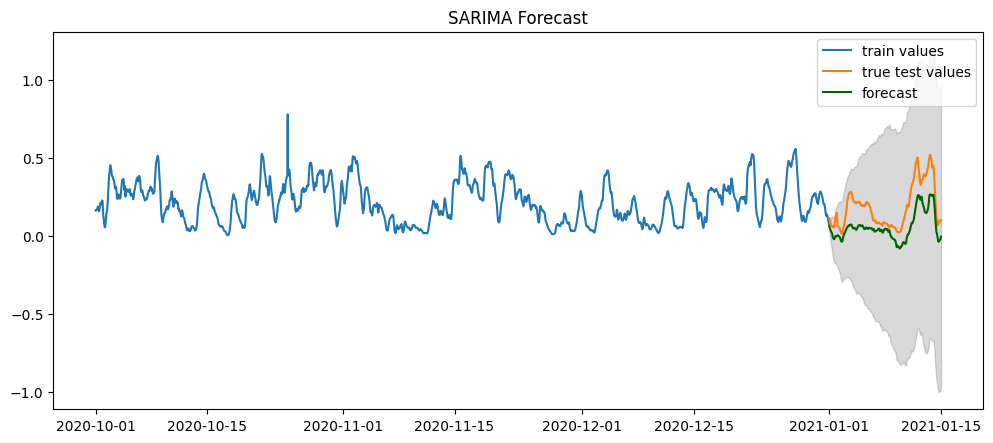

In [132]:
# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(y_train, label = "train values")
plt.plot(y_test, label = "true test values")
plt.plot(central, color='darkgreen',label = "forecast")
plt.fill_between(lower.index, 
                 lower, 
                 upper, 
                 color='k', alpha=.15)

plt.title("SARIMA Forecast")
plt.legend()
plt.show()

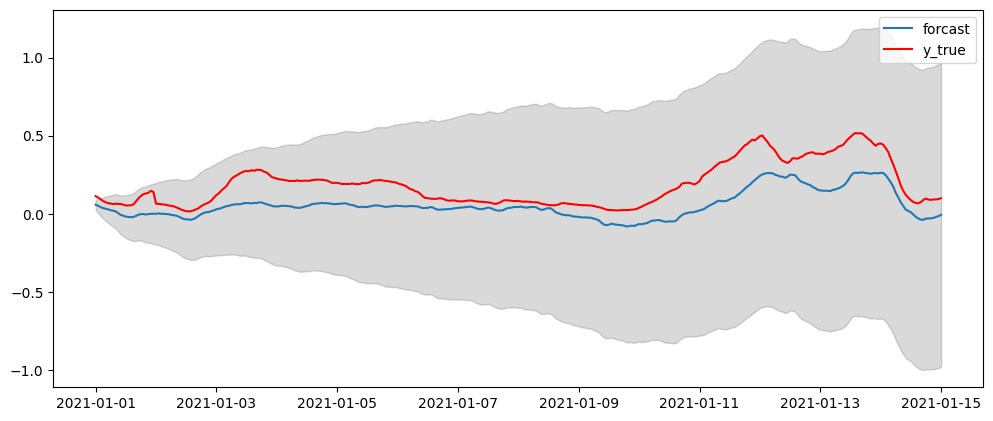

In [133]:
plt.figure(figsize=(12,5), dpi=100)
plt.plot(central, label='forcast')
plt.plot(y_test, c='r', label='y_true')
plt.fill_between(lower.index, 
                 lower, 
                 upper, 
                 color='k', alpha=.15)
plt.legend();

## SARIMAX 6

 **Model_6**:
 - Train size = 1 month
 - Test size = 4 day
 - Features: 'wind_speed', 'air_pressure', 'clouds', 'humidity', 'temperature'
 - Scaled data = false
 - model: **SARIMAX (1,1,1)(1,0,1)[24]**

In [120]:
# split data
X, y = get_X_y(target_df, features_df, init_date=dt.date(2020,12,1), end_date=dt.date(2021,1,31))
X_train, X_test, y_train, y_test = train_test_split(X, y, train_end='2020-12-31', test_init='2021-1-1', test_end='2021-1-31')

# train model
sarimax_6 = SARIMAX(y_train, 
                    exog=X_train, order=(1,1,1), 
                    seasonal_order=(1,0,1,24), 
                    time_varying_regression=False).fit()

/Users/R/.pyenv/versions/3.8.6/envs/predict_energy_generation/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [121]:
sarimax_6.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  744
Model:             SARIMAX(1, 1, 1)x(1, 0, 1, 24)   Log Likelihood               -5770.548
Date:                            Fri, 18 Jun 2021   AIC                          11559.095
Time:                                    18:06:10   BIC                          11600.592
Sample:                                12-01-2020   HQIC                         11575.092
                                     - 12-31-2020                                         
Covariance Type:                              opg                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
wind_speed    7069.3836    280.990     25.159      0.000    6518.654    7620.114
air_pressure   -47.8528     11.945     -4.006      0.000     -71.264     -24.441
humidity       532.1423     71.044      7.490      0.000     392.899     671.386
temperature   -658.7760    248.148     -2.655      0.008   -1145.137    -172.415
ar.L1            0.5915      0.048     12.227      0.000       0.497       0.686
ma.L1           -0.0717      0.062     -1.159      0.247      -0.193       0.050
ar.S.L24         0.9855      0.021     48.051      0.000       0.945       1.026
ma.S.L24        -0.9447      0.045    -20.963      0.000      -1.033      -0.856
sigma2         3.36e+05   1.74e+04     19.304      0.000    3.02e+05     3.7e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                18.53
Prob(Q):                              0.92   Prob(JB):                         0.00
Heteroskedasticity (H):               1.34   Skew:                             0.07
Prob(H) (two-sided):                  0.02   Kurtosis:                         3.76
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [122]:
#get predicitons and confidence interval
sarimax_result = sarimax_6.get_prediction(start=X_test.index[0], end=X_test.index[-1], exog=X_test)
confint = sarimax_result.conf_int(alpha=0.05)
central = sarimax_result.predicted_mean
lower = confint['lower y']
upper = confint['upper y']

In [126]:
# MPAE
(y_test-central).abs().mean()/y_test.mean()*100

57.81137034692598

In [123]:
# model MAPE
mean_absolute_percentage_error(y_test, central)

68.50575080823917

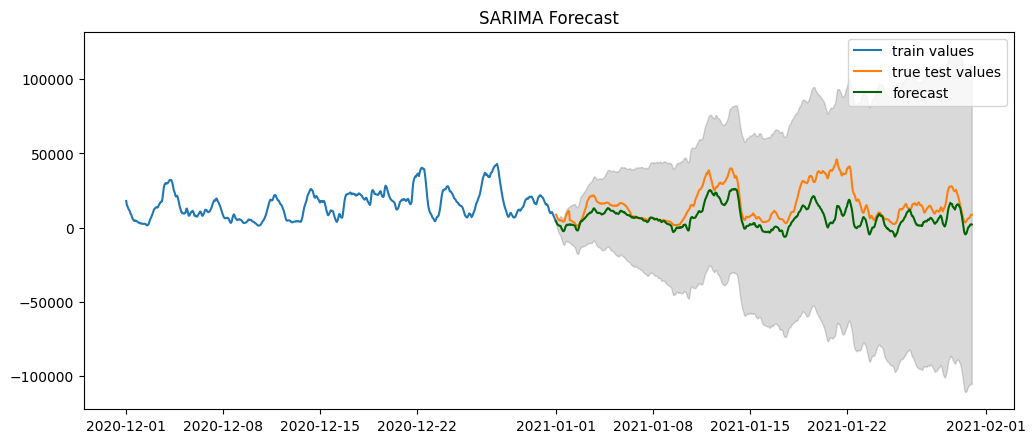

In [124]:
# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(y_train, label = "train values")
plt.plot(y_test, label = "true test values")
plt.plot(central, color='darkgreen',label = "forecast")
plt.fill_between(lower.index, 
                 lower, 
                 upper, 
                 color='k', alpha=.15)

plt.title("SARIMA Forecast")
plt.legend()
plt.show()

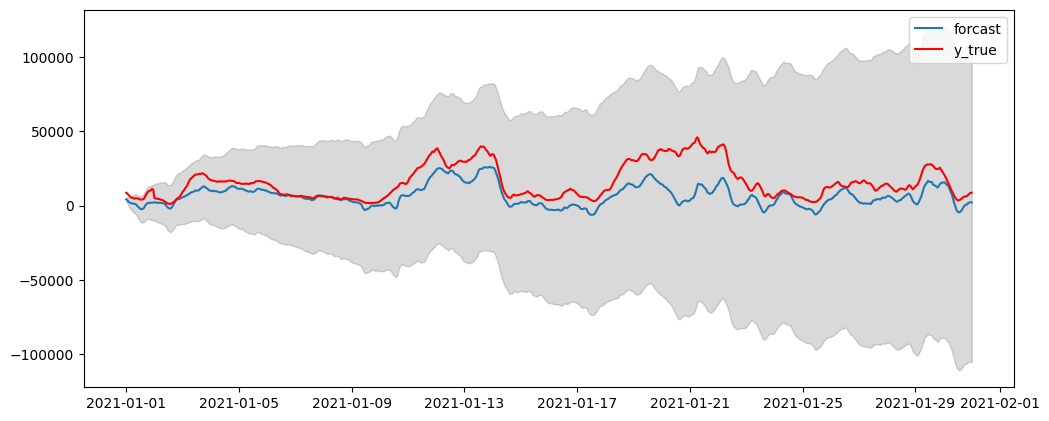

In [125]:
plt.figure(figsize=(12,5), dpi=100)
plt.plot(central, label='forcast')
plt.plot(y_test, c='r', label='y_true')
plt.fill_between(lower.index, 
                 lower, 
                 upper, 
                 color='k', alpha=.15)
plt.legend();

## SARIMAX 7

 **Model_7**:
 - Train size = 6 month
 - Test size = 4 day
 - Features: 'wind_speed', 'air_pressure', 'humidity', 'temperature'
 - Scaled data = false
 - model: **SARIMAX (1,1,2)(1,0,1)[24]**
 - time_varying_regression=True

In [96]:
# split data
X, y = get_X_y(target_df, features_df)
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [97]:
# train model
sarimax_7 = SARIMAX(y_train, 
                    exog=X_train, order=(1,1,1), 
                    seasonal_order=(1,0,2,24), 
                    time_varying_regression=True, 
                    mle_regression=False).fit()

/Users/R/.pyenv/versions/3.8.6/envs/predict_energy_generation/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [98]:
sarimax_7.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                                       y   No. Observations:                 6576
Model:             SARIMAX(1, 1, 1)x(1, 0, [1, 2], 24)   Log Likelihood              -54994.090
Date:                                 Fri, 18 Jun 2021   AIC                         110008.179
Time:                                         17:45:46   BIC                         110076.084
Sample:                                     07-01-2020   HQIC                        110031.653
                                          - 03-31-2021                                         
Covariance Type:                                   opg                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
ar.L1                0.7284      0.027     26.764      0.000       0.675       0.782
ma.L1                0.1825      0.003     71.514      0.000       0.177       0.187
ar.S.L24            -0.2048      0.054     -3.820      0.000      -0.310      -0.100
ma.S.L24             0.0731      0.008      8.942      0.000       0.057       0.089
ma.S.L48             0.0658      0.011      5.802      0.000       0.044       0.088
var.wind_speed      33.4954     30.522      1.097      0.272     -26.326      93.317
var.air_pressure     0.0011      0.019      0.061      0.952      -0.035       0.038
var.humidity         2.7282      2.590      1.054      0.292      -2.347       7.804
var.temperature     50.9017     29.315      1.736      0.083      -6.555     108.359
sigma2            1.123e+06      0.004   2.69e+08      0.000    1.12e+06    1.12e+06
===================================================================================
Ljung-Box (L1) (Q):                   3.19   Jarque-Bera (JB):          52302479.16
Prob(Q):                              0.07   Prob(JB):                         0.00
Heteroskedasticity (H):               1.95   Skew:                            -1.44
Prob(H) (two-sided):                  0.00   Kurtosis:                       440.06
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.16e+24. Standard errors may be unstable.
"""

In [99]:
#get predicitons and confidence interval
sarimax_result = sarimax_7.get_prediction(start=X_test.index[0], end=X_test.index[-1], exog=X_test)
confint = sarimax_result.conf_int(alpha=0.05)
central = sarimax_result.predicted_mean
lower = confint['lower y']
upper = confint['upper y']

In [100]:
# MPAE
(y_test-central).abs().mean()/y_test.mean()*100

47.57859248761151

In [101]:
# model MAPE
mean_absolute_percentage_error(y_test, central)

49.098764160362705

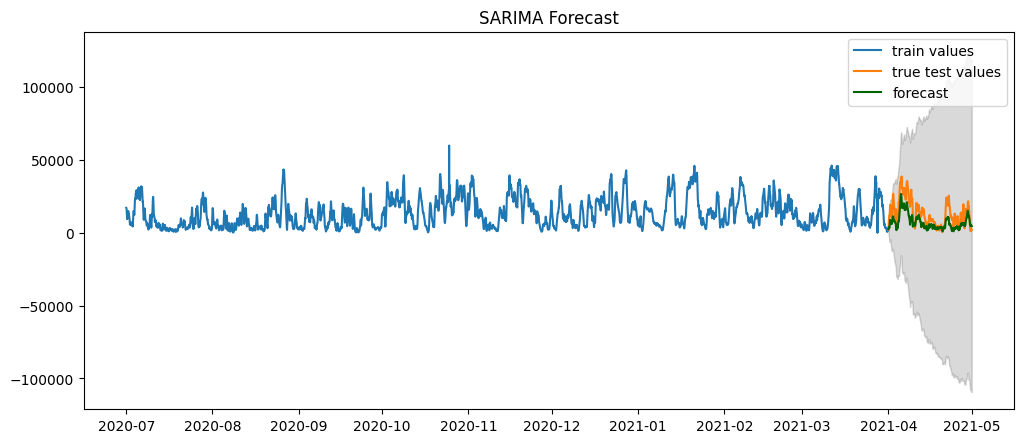

In [102]:
# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(y_train, label = "train values")
plt.plot(y_test, label = "true test values")
plt.plot(central, color='darkgreen',label = "forecast")
plt.fill_between(lower.index, 
                 lower, 
                 upper, 
                 color='k', alpha=.15)

plt.title("SARIMA Forecast")
plt.legend()
plt.show()

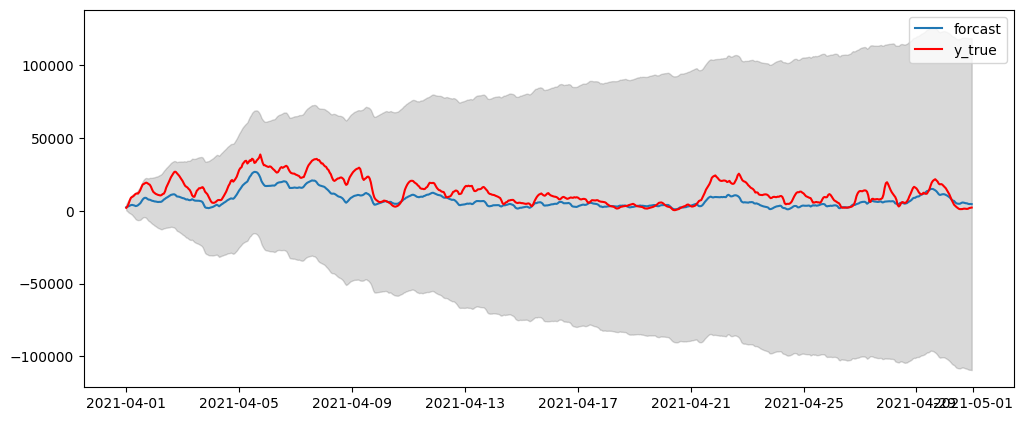

In [103]:
plt.figure(figsize=(12,5), dpi=100)
plt.plot(central, label='forcast')
plt.plot(y_test, c='r', label='y_true')
plt.fill_between(lower.index, 
                 lower, 
                 upper, 
                 color='k', alpha=.15)
plt.legend();

## SARIMAX 8

 **Model_8**:
 - Train size = 6 month
 - Test size = 4 day
 - Features: 'wind_speed', 'air_pressure', 'humidity', 'temperature'
 - Scaled data = false
 - model: **SARIMAX (1,1,2)(1,0,2)[24]**
 - time_varying_regression=False

In [104]:
# split data
X, y = get_X_y(target_df, features_df)
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [105]:
# train model
sarimax_8 = SARIMAX(y_train, 
                    exog=X_train, order=(1,1,1), 
                    seasonal_order=(1,0,2,24), 
                    time_varying_regression=False, 
                    mle_regression=True).fit()

/Users/R/.pyenv/versions/3.8.6/envs/predict_energy_generation/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [106]:
sarimax_8.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                                       y   No. Observations:                 6576
Model:             SARIMAX(1, 1, 1)x(1, 0, [1, 2], 24)   Log Likelihood              -55185.601
Date:                                 Fri, 18 Jun 2021   AIC                         110391.203
Time:                                         17:48:27   BIC                         110459.113
Sample:                                     07-01-2020   HQIC                        110414.677
                                          - 03-31-2021                                         
Covariance Type:                                   opg                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
wind_speed    3715.8851    104.601     35.525      0.000    3510.872    3920.899
air_pressure  -301.0950     15.003    -20.069      0.000    -330.501    -271.689
humidity        75.2642     22.417      3.357      0.001      31.328     119.201
temperature   -302.1338     76.379     -3.956      0.000    -451.834    -152.434
ar.L1            0.5240      0.040     12.944      0.000       0.445       0.603
ma.L1           -0.4833      0.040    -11.950      0.000      -0.563      -0.404
ar.S.L24         0.9907      0.002    539.252      0.000       0.987       0.994
ma.S.L24        -0.9720      0.003   -355.419      0.000      -0.977      -0.967
ma.S.L48        -0.0080      0.002     -4.008      0.000      -0.012      -0.004
sigma2        1.121e+06   2635.806    425.342      0.000    1.12e+06    1.13e+06
===================================================================================
Ljung-Box (L1) (Q):                 105.64   Jarque-Bera (JB):          22950949.67
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.46   Skew:                            -0.15
Prob(H) (two-sided):                  0.00   Kurtosis:                       292.44
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [107]:
#get predicitons and confidence interval
sarimax_result = sarimax_8.get_prediction(start=X_test.index[0], end=X_test.index[-1], exog=X_test)
confint = sarimax_result.conf_int(alpha=0.05)
central = sarimax_result.predicted_mean
lower = confint['lower y']
upper = confint['upper y']

In [108]:
# MPAE - mean percentage absolute error
(y_test-central).abs().mean()/y_test.mean()*100

30.758296608303

In [109]:
# model MAPE
mean_absolute_percentage_error(y_test, central)

43.436650639042206

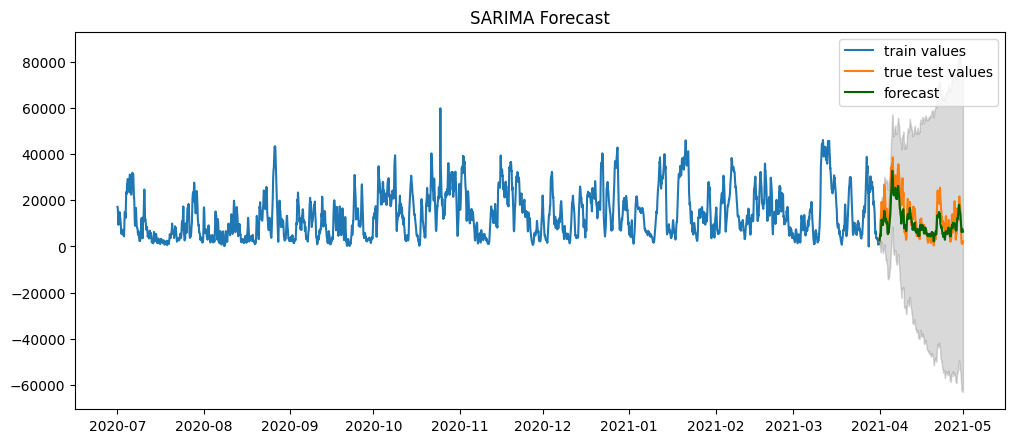

In [110]:
# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(y_train, label = "train values")
plt.plot(y_test, label = "true test values")
plt.plot(central, color='darkgreen',label = "forecast")
plt.fill_between(lower.index, 
                 lower, 
                 upper, 
                 color='k', alpha=.15)

plt.title("SARIMA Forecast")
plt.legend()
plt.show()

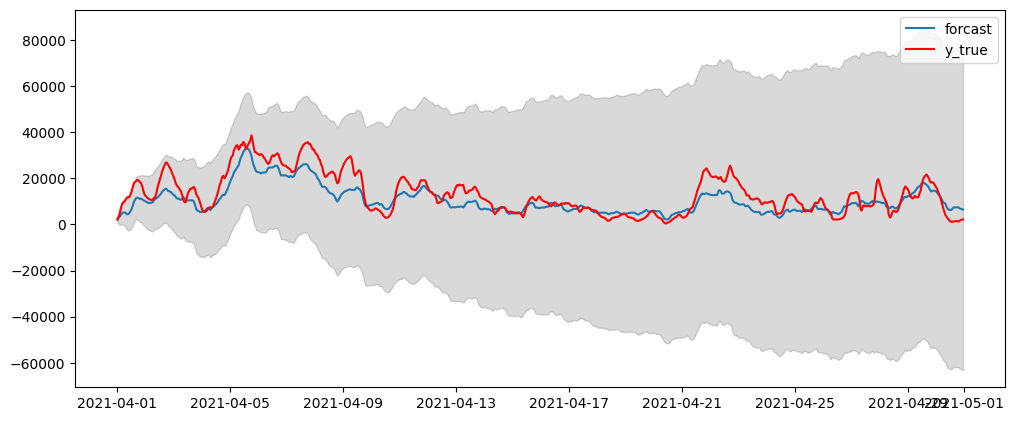

In [111]:
plt.figure(figsize=(12,5), dpi=100)
plt.plot(central, label='forcast')
plt.plot(y_test, c='r', label='y_true')
plt.fill_between(lower.index, 
                 lower, 
                 upper, 
                 color='k', alpha=.15)
plt.legend();

## SARIMAX 9

 **Model_9**:
 - Train size = 6 month
 - Test size = 30 day
 - Features: 'wind_speed', 'air_pressure', 'humidity', 'temperature'
 - Scaled data = false (comparing with the scaled features in sarmax_11, it doesn't seem an advantage)
 - model: **SARIMAX (2,1,2)(1,0,2)[24]**
 - time_varying_regression=True

In [112]:
# split data
X, y = get_X_y(target_df, features_df)
X_train, X_test, y_train, y_test = train_test_split(X, y)

# train model
sarimax_9 = SARIMAX(y_train, 
                    exog=X_train, order=(2,1,2), 
                    seasonal_order=(1,0,2,24), 
                    time_varying_regression=True, 
                    mle_regression=False).fit()

/Users/R/.pyenv/versions/3.8.6/envs/predict_energy_generation/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [113]:
sarimax_9.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                 6576
Model:             SARIMAX(2, 1, 2)x(1, 0, 2, 24)   Log Likelihood              -54905.827
Date:                            Fri, 18 Jun 2021   AIC                         109835.654
Time:                                    17:51:29   BIC                         109917.139
Sample:                                07-01-2020   HQIC                        109863.822
                                     - 03-31-2021                                         
Covariance Type:                              opg                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
ar.L1               -0.1196      0.105     -1.143      0.253      -0.325       0.085
ar.L2               -0.3847      0.122     -3.149      0.002      -0.624      -0.145
ma.L1                0.0273      0.002     14.656      0.000       0.024       0.031
ma.L2                0.0310      0.007      4.206      0.000       0.017       0.045
ar.S.L24             0.9910      0.003    370.069      0.000       0.986       0.996
ma.S.L24             0.0742      0.008      8.778      0.000       0.058       0.091
ma.S.L48            -0.0192      0.010     -1.932      0.053      -0.039       0.000
var.wind_speed       1.2455     10.816      0.115      0.908     -19.953      22.444
var.air_pressure     0.0001      0.017      0.008      0.993      -0.034       0.034
var.humidity         4.7147      2.243      2.102      0.036       0.319       9.111
var.temperature      1.5088      6.325      0.239      0.811     -10.889      13.906
sigma2            1.125e+06      0.000    1.1e+10      0.000    1.13e+06    1.13e+06
===================================================================================
Ljung-Box (L1) (Q):                  51.64   Jarque-Bera (JB):          31019020.06
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.86   Skew:                             0.13
Prob(H) (two-sided):                  0.00   Kurtosis:                       339.59
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 9.16e+25. Standard errors may be unstable.
"""

In [114]:
#get predicitons and confidence interval
sarimax_result = sarimax_9.get_prediction(start=X_test.index[0], end=X_test.index[-1], exog=X_test)
confint = sarimax_result.conf_int(alpha=0.05)
central = sarimax_result.predicted_mean
lower = confint['lower y']
upper = confint['upper y']

In [115]:
#get predicitons and confidence interval
sarimax_result = sarimax_9.get_prediction(start=X_test.index[0], end=X_test.index[-1], exog=X_test)
confint = sarimax_result.conf_int(alpha=0.05)
central = sarimax_result.predicted_mean
lower = confint['lower y']
upper = confint['upper y']

In [116]:
# MPAE
(y_test-central).abs().mean()/y_test.mean()*100

33.41227720483502

In [117]:
# model MAPE
mean_absolute_percentage_error(y_test, central)

43.44974921348486

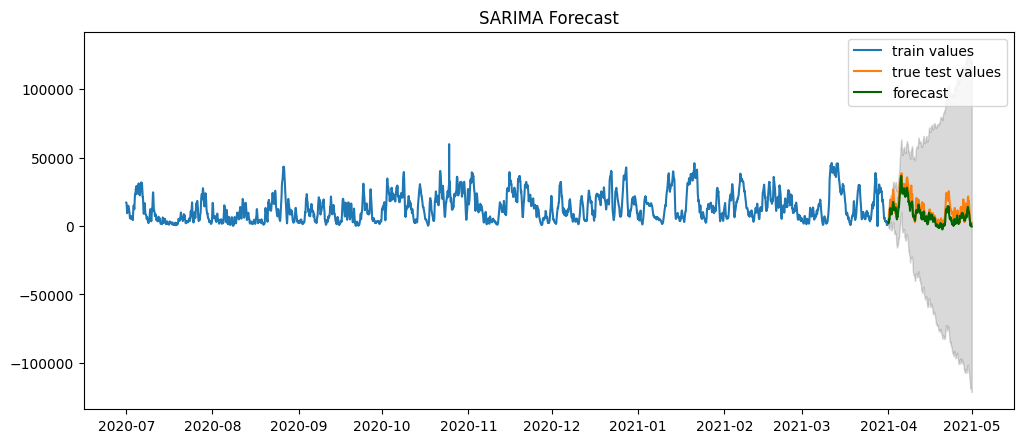

In [118]:
# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(y_train, label = "train values")
plt.plot(y_test, label = "true test values")
plt.plot(central, color='darkgreen',label = "forecast")
plt.fill_between(lower.index, 
                 lower, 
                 upper, 
                 color='k', alpha=.15)

plt.title("SARIMA Forecast")
plt.legend()
plt.show()

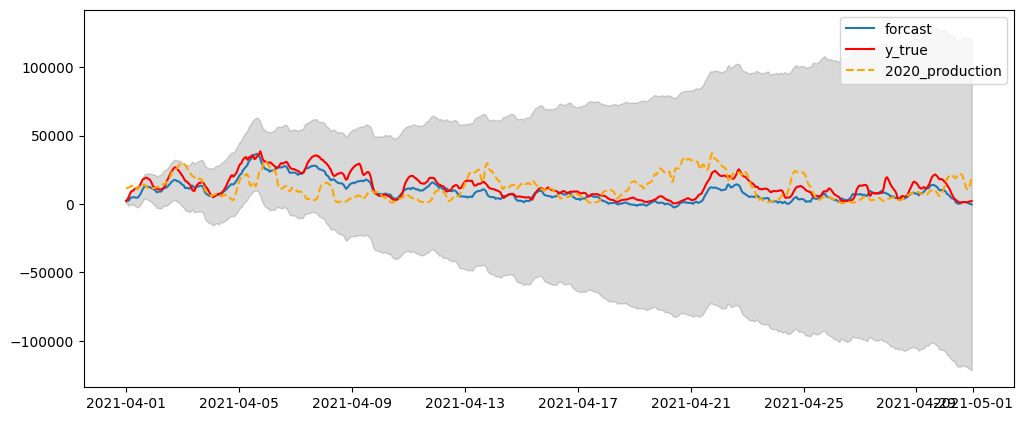

In [119]:
plt.figure(figsize=(12,5), dpi=100)
plt.plot(central, label='forcast')
plt.plot(y_test, c='r', label='y_true')
plt.fill_between(lower.index, 
                 lower, 
                 upper, 
                 color='k', alpha=.15)
plt.plot(lower.index, target_df.loc['2020-4-1':'2020-4-30'].values, ls='--', c='orange', label='2020_production')
plt.legend();

## SARIMAX 10

 **Model_10**:
 - Train size = 6 month
 - Test size = 4 day
 - Features: 'wind_speed', 'air_pressure', 'humidity', 'temperature'
 - Scaled data = features, target
 - model: **SARIMAX (2,0,1)(2,0,0)[12]**
 - time_varying_regression=False

In [141]:
# split data
X, y = get_X_y(target_df, features_df)
X_train, X_test, y_train, y_test = train_test_split(X, y)


In [142]:
# train model
sarimax_10 = SARIMAX(y_train, 
                    exog=X_train, order=(2,0,1), 
                    seasonal_order=(2,0,0,12), 
                    time_varying_regression=False, 
                    mle_regression=True).fit()

/Users/R/.pyenv/versions/3.8.6/envs/predict_energy_generation/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [143]:
sarimax_10.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                 6576
Model:             SARIMAX(2, 0, 1)x(2, 0, [], 12)   Log Likelihood              -55428.975
Date:                             Fri, 18 Jun 2021   AIC                         110877.949
Time:                                     18:15:23   BIC                         110945.861
Sample:                                 07-01-2020   HQIC                        110901.424
                                      - 03-31-2021                                         
Covariance Type:                               opg                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
wind_speed    6980.8791    113.178     61.680      0.000    6759.054    7202.705
air_pressure   -36.8035      2.471    -14.892      0.000     -41.647     -31.960
humidity       335.6046     21.732     15.443      0.000     293.012     378.198
temperature     16.0014     70.480      0.227      0.820    -122.138     154.141
ar.L1            1.6151      0.032     51.245      0.000       1.553       1.677
ar.L2           -0.6370      0.031    -20.464      0.000      -0.698      -0.576
ma.L1           -0.4509      0.031    -14.547      0.000      -0.512      -0.390
ar.S.L12         0.0232      0.011      2.180      0.029       0.002       0.044
ar.S.L24         0.1973      0.003     59.747      0.000       0.191       0.204
sigma2        1.272e+06   3329.825    382.023      0.000    1.27e+06    1.28e+06
===================================================================================
Ljung-Box (L1) (Q):                   5.45   Jarque-Bera (JB):          29855765.21
Prob(Q):                              0.02   Prob(JB):                         0.00
Heteroskedasticity (H):               1.70   Skew:                            -0.47
Prob(H) (two-sided):                  0.00   Kurtosis:                       333.09
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [144]:
#get predicitons and confidence interval
sarimax_result = sarimax_10.get_prediction(start=X_test.index[0], end=X_test.index[-1], exog=X_test)
confint = sarimax_result.conf_int(alpha=0.05)
central = sarimax_result.predicted_mean
lower = confint['lower y']
upper = confint['upper y']

In [145]:
# MPAE
(y_test-central).abs().mean()/y_test.mean()*100

25.941693253869992

In [146]:
# model MAPE
mean_absolute_percentage_error(y_test, central)

45.80584526051089

In [147]:
mae(y_test, central)

3433.775830561453

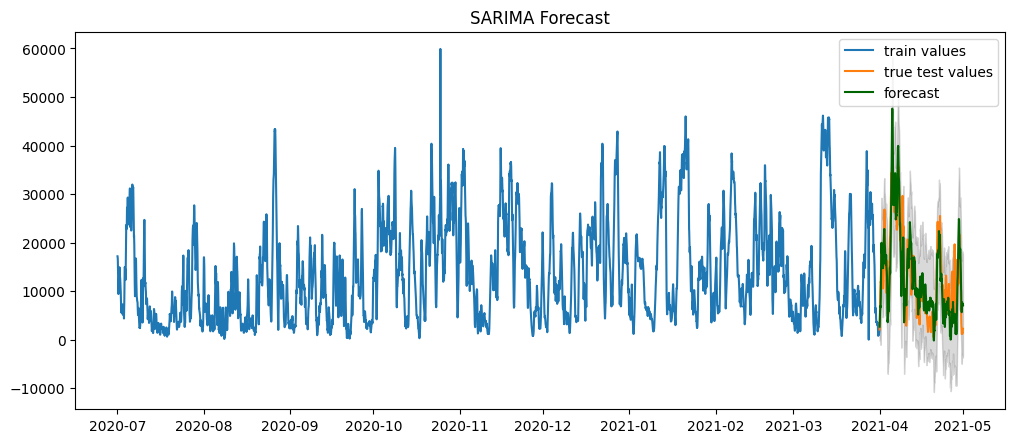

In [148]:
# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(y_train, label = "train values")
plt.plot(y_test, label = "true test values")
plt.plot(central, color='darkgreen',label = "forecast")
plt.fill_between(lower.index, 
                 lower, 
                 upper, 
                 color='k', alpha=.15)

plt.title("SARIMA Forecast")
plt.legend()
plt.show()

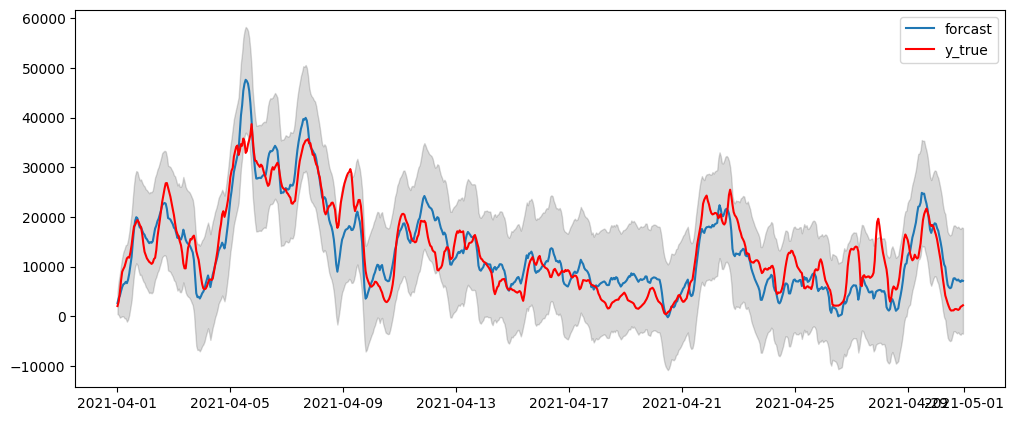

In [149]:
plt.figure(figsize=(12,5), dpi=100)
plt.plot(central, label='forcast')
plt.plot(y_test, c='r', label='y_true')
plt.fill_between(lower.index, 
                 lower, 
                 upper, 
                 color='k', alpha=.15)
plt.legend();

## SARIMAX 11

 **Model_11**:
 - Train size = 6 month
 - Test size = 30 day
 - Features: 'wind_speed', 'air_pressure', 'humidity', 'temperature'
 - Scaled data = target and features
 - model: **SARIMAX (2,1,2)(1,0,2)[24]**
 - time_varying_regression=True

In [215]:
# split data
X, y = get_X_y(target_scaled_df, feat_scaled_df)
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [162]:
# train model
sarimax_11 = SARIMAX(y_train, 
                    exog=X_train, order=(2,1,2), 
                    seasonal_order=(1,0,2,24), 
                    time_varying_regression=True, 
                    mle_regression=False).fit()

In [163]:
sarimax_11.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                 6576
Model:             SARIMAX(2, 1, 2)x(1, 0, 2, 24)   Log Likelihood               19050.133
Date:                            Fri, 18 Jun 2021   AIC                         -38076.267
Time:                                    18:57:53   BIC                         -37994.782
Sample:                                07-01-2020   HQIC                        -38048.099
                                     - 03-31-2021                                         
Covariance Type:                              opg                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
ar.L1                0.3439   1.91e-13    1.8e+12      0.000       0.344       0.344
ar.L2                0.0546   1.59e-13   3.43e+11      0.000       0.055       0.055
ma.L1               -0.1603   8.93e-14   -1.8e+12      0.000      -0.160      -0.160
ma.L2                0.0649   1.38e-13   4.72e+11      0.000       0.065       0.065
ar.S.L24             0.5147   1.42e-13   3.62e+12      0.000       0.515       0.515
ma.S.L24            -0.4218   2.54e-13  -1.66e+12      0.000      -0.422      -0.422
ma.S.L48             0.0422   9.35e-14   4.52e+11      0.000       0.042       0.042
var.wind_speed       0.0028   3.86e-05     72.623      0.000       0.003       0.003
var.air_pressure  6.052e-05   3.56e-06     16.990      0.000    5.35e-05    6.75e-05
var.humidity       7.46e-05    4.8e-06     15.548      0.000    6.52e-05     8.4e-05
var.temperature   2.176e-05   5.57e-06      3.906      0.000    1.08e-05    3.27e-05
sigma2            3.047e-10   2.26e-06      0.000      1.000   -4.43e-06    4.43e-06
===================================================================================
Ljung-Box (L1) (Q):                 247.36   Jarque-Bera (JB):          13220941.53
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.30   Skew:                            -0.01
Prob(H) (two-sided):                  0.00   Kurtosis:                       222.75
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.11e+32. Standard errors may be unstable.
"""

In [216]:
#get predicitons and confidence interval
sarimax_result = sarimax_11.get_prediction(start=X_test.index[0], end=X_test.index[-1], exog=X_test)
confint = sarimax_result.conf_int(alpha=0.05)
central = sarimax_result.predicted_mean
lower = confint['lower y']
upper = confint['upper y']

In [217]:
# MPAE
(y_test-central).abs().mean()/y_test.mean()*100

81.58973970175373

In [218]:
# model MAPE
mean_absolute_percentage_error(y_test, central)

74.02373236476333

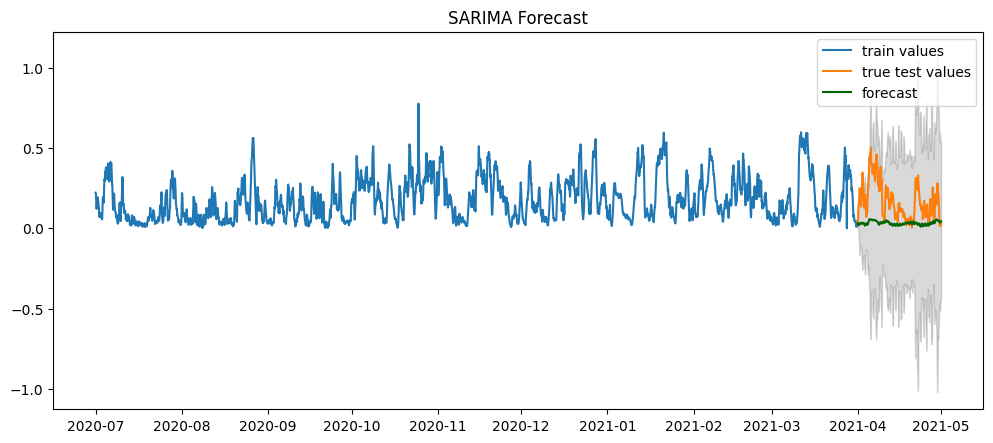

In [219]:
# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(y_train, label = "train values")
plt.plot(y_test, label = "true test values")
plt.plot(central, color='darkgreen',label = "forecast")
plt.fill_between(lower.index, 
                 lower, 
                 upper, 
                 color='k', alpha=.15)

plt.title("SARIMA Forecast")
plt.legend()
plt.show()

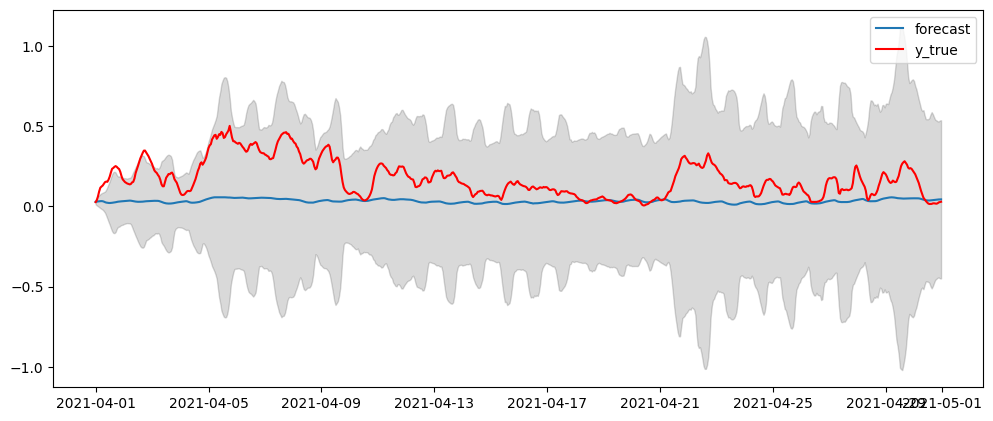

In [222]:
plt.figure(figsize=(12,5), dpi=100)
plt.plot(central, label='forecast')
plt.plot(y_test, c='r', label='y_true')
plt.fill_between(lower.index, 
                 lower, 
                 upper, 
                 color='k', alpha=.15)
#plt.plot(lower.index, target_pipe.transform(target_df.loc['2020-4-1':'2020-4-30'].values.reshape(-1, 1)), ls='--', c='orange', label='2020_production')
plt.legend();

## SARIMAX 12

 **Model_12**:
 - Changed the aggredating method for the features df to sum <== NOT A BETTER SOLUTION (see SARIMAX_9)
 - Train size = 6 month
 - Test size = 30 day
 - Features: 'wind_speed', 'air_pressure', 'humidity', 'temperature'
 - Scaled data = false
 - model: **SARIMAX (2,1,2)(1,0,2)[24]**
 - time_varying_regression=True

In [169]:
# split data
X, y = get_X_y(target_df, features_df)
X_train, X_test, y_train, y_test = train_test_split(X, y)
# train model
sarimax_12 = SARIMAX(y_train, 
                    exog=X_train, order=(2,1,2), 
                    seasonal_order=(1,0,2,24), 
                    time_varying_regression=True, 
                    mle_regression=False).fit()

/Users/R/.pyenv/versions/3.8.6/envs/predict_energy_generation/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [183]:
sarimax_12.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                 6576
Model:             SARIMAX(2, 1, 2)x(1, 0, 2, 24)   Log Likelihood              -54905.827
Date:                            Sat, 19 Jun 2021   AIC                         109835.654
Time:                                    09:52:25   BIC                         109917.139
Sample:                                07-01-2020   HQIC                        109863.822
                                     - 03-31-2021                                         
Covariance Type:                              opg                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
ar.L1               -0.1196      0.105     -1.143      0.253      -0.325       0.085
ar.L2               -0.3847      0.122     -3.149      0.002      -0.624      -0.145
ma.L1                0.0273      0.002     14.656      0.000       0.024       0.031
ma.L2                0.0310      0.007      4.206      0.000       0.017       0.045
ar.S.L24             0.9910      0.003    370.069      0.000       0.986       0.996
ma.S.L24             0.0742      0.008      8.778      0.000       0.058       0.091
ma.S.L48            -0.0192      0.010     -1.932      0.053      -0.039       0.000
var.wind_speed       1.2455     10.816      0.115      0.908     -19.953      22.444
var.air_pressure     0.0001      0.017      0.008      0.993      -0.034       0.034
var.humidity         4.7147      2.243      2.102      0.036       0.319       9.111
var.temperature      1.5088      6.325      0.239      0.811     -10.889      13.906
sigma2            1.125e+06      0.000    1.1e+10      0.000    1.13e+06    1.13e+06
===================================================================================
Ljung-Box (L1) (Q):                  51.64   Jarque-Bera (JB):          31019020.06
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.86   Skew:                             0.13
Prob(H) (two-sided):                  0.00   Kurtosis:                       339.59
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 9.16e+25. Standard errors may be unstable.
"""

In [194]:
#get predicitons and confidence interval
sarimax_result = sarimax_12.get_prediction(start=X_test.index[0], end=X_test.index[-1], exog=X_test)
confint = sarimax_result.conf_int(alpha=0.05)
central = sarimax_result.predicted_mean
lower = confint['lower y']
upper = confint['upper y']

In [195]:
# MPAE
(y_test-central).abs().mean()/y_test.mean()*100

33.41227720483502

In [196]:
# model MAPE
mean_absolute_percentage_error(y_test, central)

43.44974921348486

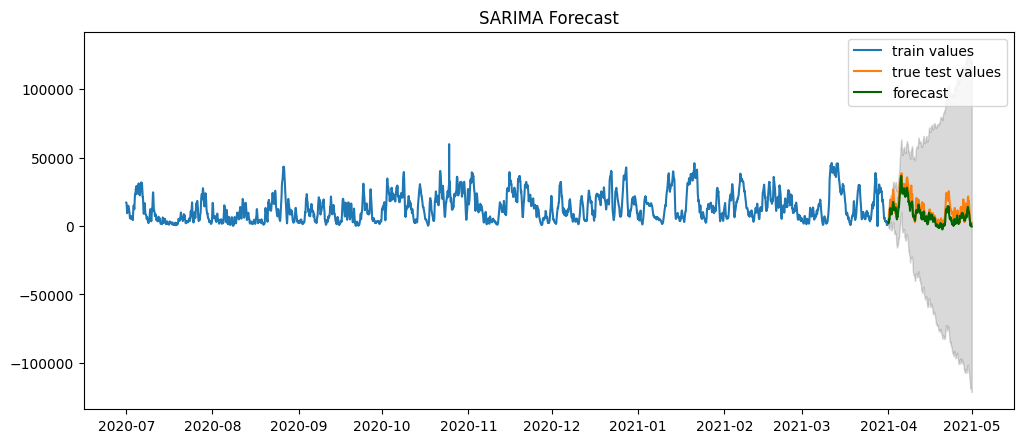

In [197]:
# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(y_train, label = "train values")
plt.plot(y_test, label = "true test values")
plt.plot(central, color='darkgreen',label = "forecast")
plt.fill_between(lower.index, 
                 lower, 
                 upper, 
                 color='k', alpha=.15)

plt.title("SARIMA Forecast")
plt.legend()
plt.show()

In [198]:
#lower=lower.apply(lambda x: x if x >0 else 0)

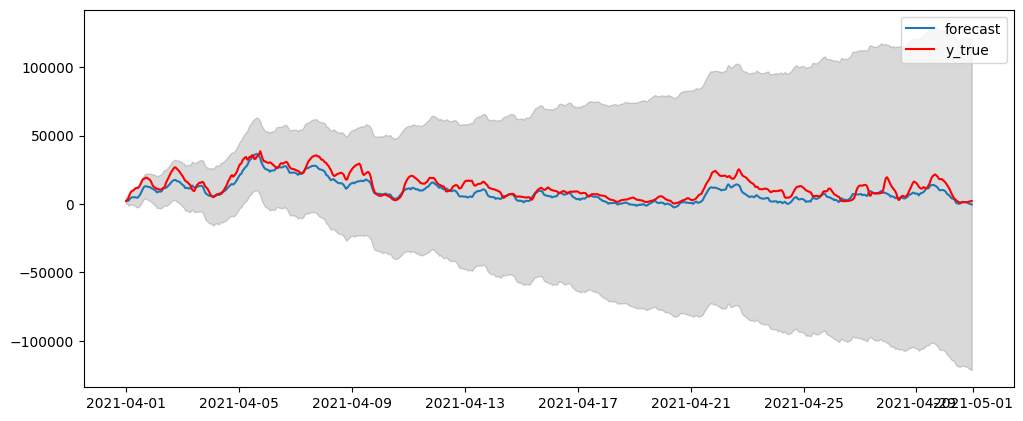

In [200]:
plt.figure(figsize=(12,5), dpi=100)
plt.plot(central, label='forecast')
plt.plot(y_test, c='r', label='y_true')
plt.fill_between(lower.index, 
                 lower, 
                 upper, 
                 color='k', alpha=.15)
#plt.plot(lower.index, target_df.loc['2020-4-1':'2020-4-30'].values, ls='--', c='orange', label='2020_production')
plt.legend();

## RandomForest

In [448]:
df = pd.DataFrame(target_df, columns=['production']).copy()
df["x_1"] = df["production"].shift(1)
df["x_2"] = df["production"].shift(2)
df["x_3"] = df["production"].shift(3)
df["x_4"] = df["production"].shift(4)
df["x_5"] = df["production"].shift(5)
df["x_6"] = df["production"].shift(6)
df["x_7"] = df["production"].shift(7)
df["x_8"] = df["production"].shift(8)
df["x_9"] = df["production"].shift(9)
df["x_10"] = df["production"].shift(10)
df["x_11"] = df["production"].shift(11)
df["x_12"] = df["production"].shift(12)

In [449]:
# Extract the trend using a well chosen moving average
df['ma_24'] = df['x_2'].rolling(window=24).mean()
df['ma_12'] = df['x_2'].rolling(window=12).mean()
df['ma_3'] = df['x_2'].rolling(window=3).mean()
df['ma_2'] = df['x_2'].rolling(window=2).mean()

df["ewma_2"] = df["x_2"].ewm(halflife=2).mean()
df["ewma_3"] = df["x_2"].ewm(halflife=3).mean()
df["ewma_12"] = df["x_2"].ewm(halflife=12).mean()
df["ewma_24"] = df["x_2"].ewm(halflife=24).mean()

In [450]:
# Drop nan
df = df.dropna()

#train test split
X, y = get_X_y(df.production, df.drop('production', axis=1), init_date=dt.date(2020,10,1), end_date=dt.date(2021,1,3), scaled=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_hours=24)

In [451]:
from sklearn.ensemble import RandomForestRegressor

random_forest = RandomForestRegressor(n_estimators=100, random_state=42)

In [65]:
# Keep track of test_indexes
test_indexes = np.arange(len(X_train), len(X))
test_indexes

array([2233, 2234, 2235, 2236, 2237, 2238, 2239, 2240, 2241, 2242, 2243,
       2244, 2245, 2246, 2247, 2248, 2249, 2250, 2251, 2252, 2253, 2254,
       2255, 2256])

In [66]:
# For each predictor, design a method to evaluate its performance on the test set:
from sklearn.metrics import r2_score
def evaluate_performance_month_prediction(y_true, test_indexes, predictor, full_X):
    predictions = []
    ground_truth = []
    i = 0
    for _indx in test_indexes:
        train_data = y_true[:_indx]
        current_ground_truth = y_true[_indx]
        current_ground_truth_features = full_X[_indx,:]
        train_features = full_X[:_indx]
        # train the model on all datapoint until (t-1) in order to predict (t)
        predictor.fit(train_features, train_data)
        prediction = predictor.predict(current_ground_truth_features.reshape(1,-1))[0]
        predictions.append(prediction)
        ground_truth.append(current_ground_truth)
        i += 1
    mape = np.mean(np.abs(np.array(predictions) - np.array(ground_truth))/np.abs(np.array(ground_truth)))
    return ground_truth, predictions, mape

In [462]:
def get_next_features(train_features, train_target):
    data = pd.DataFrame(np.append(train_target.reshape(-1,1),train_features, axis=1), columns=df.columns)
    t_feat = pd.Series(index=X.columns, dtype='float64')
    #print(data.index[-1])
    for _t in range(1,13):
        exec(f't_feat["x_{_t}"] = data.iloc[-{_t}]["production"]')
    for _t in [2, 3, 12, 24]:
        #print(data['x_2'].append(pd.Series(t_feat['x_1'])).rolling(window=_t).mean().iloc[-1])
        exec(f"t_feat['ma_{_t}'] = data['x_1'].append(pd.Series(t_feat['x_1'])).rolling(window={_t}).mean().iloc[-1]")
        exec(f"t_feat['ewma_{_t}'] = data['x_1'].append(pd.Series(t_feat['x_1'])).ewm(halflife={_t}).mean().iloc[-1]")
    return t_feat.values

def evaluate_performance_hourly_prediction(y_train, y_test, predictor, X):
    predictions = []
    train_target = y_train.values
    train_features = X.values
    i=0
    for _ in range(len(y_test)):
        # train the model on all datapoint until (t-1) in order to predict (t)
        predictor.fit(train_features, train_target)
        next_features = get_next_features(train_features, train_target)
        prediction = predictor.predict(next_features.reshape(1,-1))[0]
        #print(np.array([prediction]).shape)
        train_target = np.append(train_target, np.array([prediction]), axis=0)
        train_features = np.append(train_features, next_features.reshape(1,-1), axis=0)
        predictions.append(prediction)
        i+=1
    #print(i)
    mape = np.mean(np.abs(np.array(predictions) - np.array(y_test))/np.abs(np.array(y_test)))
    return y_test, predictions, mape

In [463]:
results = evaluate_performance_hourly_prediction(y_train=y_train, y_test=y_test,
                                                         predictor=random_forest, X=X_train)

In [452]:
results = evaluate_performance_month_prediction(y.values, test_indexes=test_indexes,
                                                         predictor=random_forest, full_X = X.values)

In [464]:
# MAPE
results[2]

0.670809018654846

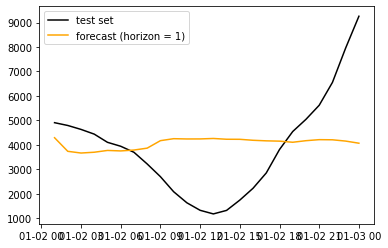

In [465]:
plt.plot(results[0], c='black', label='test set')
plt.plot(pd.Series(results[1], index=results[0].index), c='orange', label='forecast (horizon = 1)')
plt.legend()

In [466]:
importances = random_forest.feature_importances_
pd.DataFrame(zip(importances, list(X_train.columns))).sort_values(by=0, ascending=False)

,0,1
0,0.987438,x_1
1,0.002145,x_2
2,0.001143,x_3
15,0.001138,ma_2
3,0.001109,x_4
14,0.000872,ma_3
16,0.000679,ewma_2
12,0.000541,ma_24
11,0.000531,x_12
19,0.000528,ewma_24


# Save model (and scalers)

In [475]:
sarimax_9.save('/Users/R/code/HaukeFock/predict_energy_generation/predict_energy_generation/data/models/wind_model_4.pkl')

# Evaluations

In [20]:
def mae(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    return np.sum(np.abs(y_true-y_pred))/(len(y_true))

def mse(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    return np.mean((y_true-y_pred)**2)

def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

## model_8

In [ ]:
y_pred = model_8.forecast(len(y_test), exog=X_test, alpha=0.05)

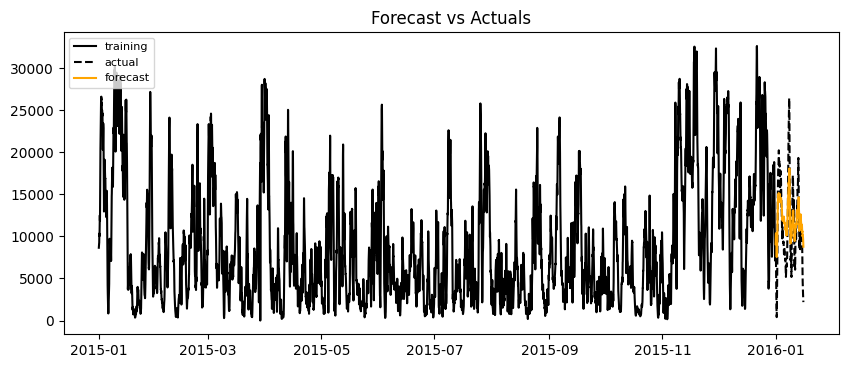

In [58]:
plot_forecast(y_pred, y_train, y_test)

In [45]:
model_8.mae

340.0432823356836

In [48]:
mae(y_test, y_pred)

3474.8045601605695

In [49]:
mse(y_test, y_pred)

17229826.977893803

In [50]:
mean_absolute_percentage_error(y_test, y_pred)

62.571837013493834

## model_10

In [71]:
y_pred = model_10.forecast(len(y_test), exog=X_test, alpha=0.05)

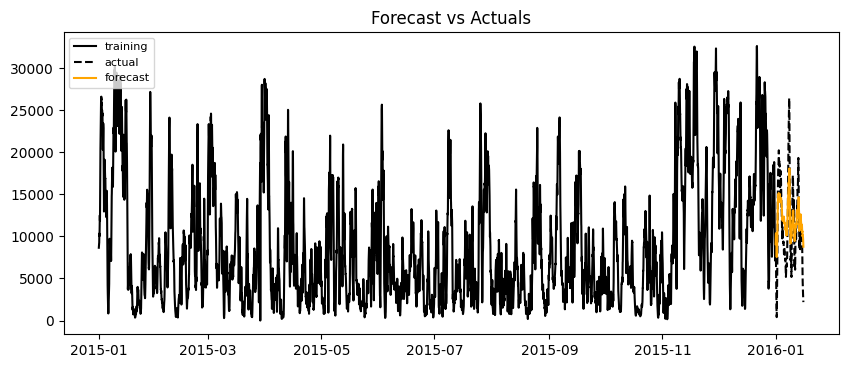

In [58]:
plot_forecast(y_pred, y_train, y_test)

In [72]:
mae(y_test, y_pred)

2827.8653712675423

In [73]:
mse(y_test, y_pred)

11652640.658651238

In [74]:
mean_absolute_percentage_error(y_test, y_pred)

50.545070786224656

## model_11

In [87]:
y_pred = model_11.forecast(len(y_test), exog=X_test, alpha=0.05)

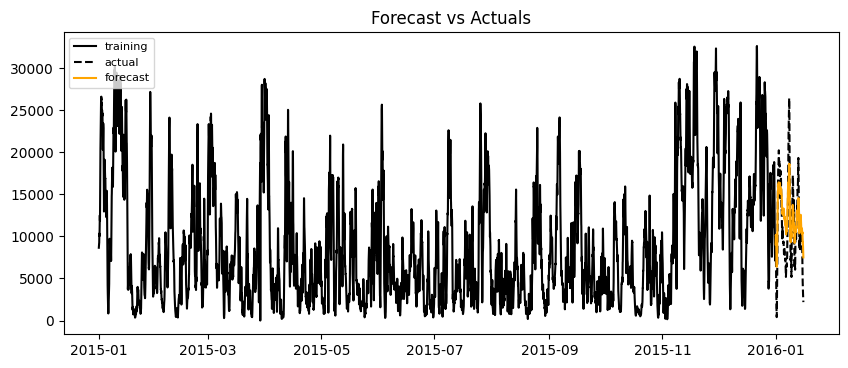

In [88]:
plot_forecast(y_pred, y_train, y_test)

In [89]:
mae(y_test, y_pred)

2741.0597859021373

In [90]:
mse(y_test, y_pred)

10602976.346378602

In [91]:
mean_absolute_percentage_error(y_test, y_pred)

47.22682448948714

## model_12

<AxesSubplot:xlabel='Date'>

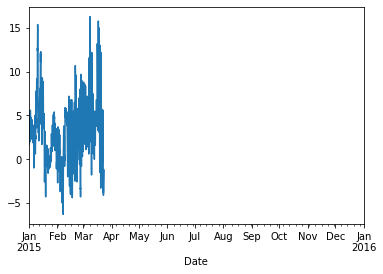

In [105]:
X_train['air_pressure'].plot()

In [104]:
X_train.isna().sum()

wind_speed         0
air_pressure    6808
dtype: int64

In [101]:
model_12 = SARIMAX(endog=y_train, exog=X_train, order=(1,1,2), seasonal_order=(2,0,0,24)).fit()

MissingDataError: exog contains inf or nans

In [57]:
y_pred = model_12.forecast(len(y_test), exog=X_test, alpha=0.05)

## baseline

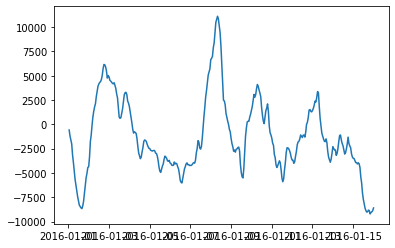

In [43]:
residuals = y_test - y_pred
plt.plot(residuals)

In [46]:
sarimax.mae

340.0432823356836

In [36]:
mae(y_test, forecast)

3474.8045601605695

In [37]:
sarimax.mse

370485.49749783427

In [38]:
mse(y_test, forecast)

17229826.977893803

In [39]:
mean_absolute_percentage_error(y_test, forecast)

62.571837013493834

In [34]:
# asbolute values MAPE
baseline = mean_absolute_percentage_error(y_test, forecast)
baseline

8.52754434601609

In [35]:
# log values MAPE
log_baseline = mean_absolute_percentage_error(np.log(y_test), np.log(forecast))
log_baseline

0.8707221647966732

In [67]:
# SMARD forcast MAPE
mean_absolute_percentage_error(y_test, forcasted_df.loc[dt.date(2016,1,1):dt.date(2016,3,31)])

NameError: name 'forcasted_df' is not defined

In [ ]:
# SMARD log forcast MAPE
THE_BAR = mean_absolute_percentage_error(y_test, np.log(mini_forecast))
THE_BAR

# scrap

In [577]:
df = pd.read_csv('/Users/R/code/HaukeFock/predict_energy_generation/predict_energy_generation/data/temp_df.csv')

df['Date'] = pd.to_datetime(df.Date)
df.set_index('Date', inplace=True)

In [578]:
df.shape

(2880, 515)

In [572]:
df.head()
#df.tail()

,44,71,73,78,91,96,102,125,131,142,...,13711,13713,13777,13965,15000,15207,15444,15555,19171,19172
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-01 00:00:00,2.2,-3.7,-2.1,1.6,0.6,NaN,3.9,-9.6,1.1,-1.7,...,1.9,1.1,4.2,-2.9,1.2,0.1,-2.2,NaN,NaN,NaN
2015-01-01 01:00:00,2.5,-3.8,-1.7,1.9,0.5,NaN,3.3,-8.8,1.3,-2.3,...,1.7,0.9,3.7,-5.2,1.0,-0.8,-1.8,NaN,NaN,NaN
2015-01-01 02:00:00,2.3,-4.4,-1.8,1.6,0.3,NaN,3.7,-12.5,1.2,-2.5,...,1.6,1.0,3.1,-5.3,1.1,-1.4,-2.3,NaN,NaN,NaN
2015-01-01 03:00:00,2.3,-3.2,-2.0,1.5,0.4,NaN,3.8,-11.0,1.4,-4.0,...,1.5,0.9,1.8,-4.0,0.5,-1.7,-3.5,NaN,NaN,NaN
2015-01-01 04:00:00,1.9,-3.4,-1.7,1.5,0.4,NaN,3.8,-10.6,1.5,-4.6,...,1.2,0.9,2.2,-3.6,0.9,-1.5,-1.6,NaN,NaN,NaN


In [573]:
df = df.loc['2021-1-1':]

In [574]:
DATA_PATH = '/Users/R/code/HaukeFock/predict_energy_generation/predict_energy_generation/data'
df.to_csv(f'{DATA_PATH}/temp_df.csv')

In [502]:
!ls /Users/R/code/HaukeFock/predict_energy_generation/predict_energy_generation/data

humidity_df.csv         radiation_df.csv        windspeed_df.csv
models                  temp_df.csv
pressure_df.csv         weather_stations_df.csv
